Import latest pyopenms from source:

In [ ]:
import sys
sys.path.insert(0, '/home/eeko/openms-develop/openms-build/pyOpenMS')
from pyopenms import *

## Convert files from Thermo

ThermoRawFileParser https://github.com/compomics/ThermoRawFileParser

Convert profile MS1 data from Thermo raw files to centroid (MS1 and MS2) mzml

In [ ]:
!mono resources/ThermoRawFileParser/ThermoRawFileParser.exe -d="data/raw/" -o="results/interim"

#### Copy all the files to data/raw directory and you can use the following script to generate a samples.tsv file automatically:

In [ ]:
!(cd data/raw && ls *.raw > filelist.txt)
import pandas as pd
header_list = ["sample_name"]
df=pd.read_csv("data/raw/filelist.txt", names=header_list)
df["sample_name"]=df["sample_name"].replace(".raw", value="", regex=True)
#df["sample_name"]=df["sample_name"].replace(to_replace= r'NBC', value= 'NBC_', regex= True)
df["sample_name"]=df["sample_name"].replace(to_replace= r'MDNAWGS', value= 'MDNA_WGS_', regex= True)
df["comment"] = ""
df["MAPnumber"] = ""
df.to_csv("data/raw/samples.tsv", sep="\t")
df

## Import libraries

In [3]:
from pyopenms import *
from pandas import DataFrame
import pandas as pd
import numpy as np
import os
import glob


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


# Preprocessing step

## The first preprocessing function consists of five steps:

### 1) PrecursorCorrection (To the "highest intensity MS1 peak")

This algorithm is used directly after the file introduction, in order to correct any wrong MS1 precursor annotation - this means it will correct the precursos m/z in a given mass range (e.g. 0.1 Da) and then use the highest intensity peak as the precursor. We assume that, in the given mass window, the precursor with the hightest intensity was actually fragmented (top-n method), which is a method used by default in the Thermo Orbitrap instrument (Center for Biosustainability).

### OpenMS definition:

"Selection of the peak with the highest intensity as corrected precursor mass in a given mass range (e.g. precursor mass +/- 0.2 Da)

For each MS2 spectrum the corresponding MS1 spectrum is determined by using the rt information of the precursor. In the MS1, the peak with the highest intensity in a given mass range to the uncorrected precursor m/z is selected and used as corrected precursor m/z."

#### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html//classOpenMS_1_1PrecursorCorrection.html#a8acf85ba8b9f249de0369bb083355982 

###### Citation: Röst, H.L., Sachsenberg, T., Aiche, S., Bielow, C., Weisser, H., Aicheler, F., Andreotti, S., Ehrlich, H.-C., Gutenbrunner, P., Kenar, E., Liang, X., Nahnsen, S., Nilse, L., Pfeuffer, J., Rosenberger, G., Rurik, M., Schmitt, U., Veit, J., Walzer, M., Wojnar, D., Wolski, W.E.,Schilling, O., Choudhary, J.S., Malmström, L., Aebersold, R., Reinert, K., Kohlbacher, O. OpenMS: A flexible open-source software platform for mass spectrometry data analysis. Nature Methods, vol. 13, 2016. doi:10.1038/nmeth.3959

In [ ]:
path= "results/interim"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_original_files = glob.glob('results/interim/*.mzML')
    
for filename in input_original_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    delta_mzs= []
    mzs = []
    rts= []
    PrecursorCorrection.correctToHighestIntensityMS1Peak(exp, 100.0, True, delta_mzs, mzs, rts)
    mzmlfile_path = os.path.join(os.path.dirname(filename), 'PCpeak_' + os.path.basename(filename))
    MzMLFile().store(mzmlfile_path, exp)

In [ ]:
path= "results/features/interim"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_mzml_files = glob.glob('results/interim/PCpeak_*.mzML')

# 2) Mass trace detection

#A mass trace extraction method that gathers peaks similar in m/z and moving along retention time.
#Peaks of a MSExperiment are sorted by their intensity and stored in a list of potential chromatographic apex positions. Only peaks that are above the noise threshold (user-defined) are analyzed and only peaks that are n times above this minimal threshold are considered as apices. This saves computational resources and decreases the noise in the resulting output.
#Starting with these, mass traces are extended in- and decreasingly in retention time. During this extension phase, the centroid m/z is computed on-line as an intensity-weighted mean of peaks.
#The extension phase ends when either the frequency of gathered peaks drops below a threshold (min_sample_rate, see MassTraceDetection parameters) or when the number of missed scans exceeds a threshold (trace_termination_outliers, see MassTraceDetection parameters).
#Finally, only mass traces that pass a filter (a certain minimal and maximal length as well as having the minimal sample rate criterion fulfilled) get added to the result.
#### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1MassTraceDetection.html#abff6e392ce6da7af8f083397494a7971

for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)
    mass_traces = []
    mtd = MassTraceDetection()
    mtd_par = mtd.getDefaults()
    mtd_par.setValue("mass_error_ppm", 10.0) 
    mtd_par.setValue("noise_threshold_int", 1.0e04)
    mtd.setParameters(mtd_par)
    mtd.run(exp, mass_traces, 0)

# 3) Elution peak detection

#Extracts chromatographic peaks from a mass trace.
#Mass traces may consist of several consecutively (partly overlapping) eluting peaks, e.g., stemming from (almost) isobaric compounds that are separated by retention time. Especially in metabolomics, isomeric compounds with exactly the same mass but different retentional behaviour may still be contained in the same mass trace.
#This method first applies smoothing on the mass trace's intensities, then detects local minima/maxima in order to separate the chromatographic peaks from each other. Detection of maxima is performed on the smoothed intensities and uses a fixed peak width (given as parameter chrom_fwhm) within which only a single maximum is expected. Currently smoothing is done using SavitzkyGolay smoothing with a second order polynomial and a frame length of the fixed peak width.
#Depending on the "width_filtering" parameters, mass traces are filtered by length in seconds ("fixed" filter) or by quantile.
#The output of the algorithm is a set of chromatographic peaks for each mass trace, i.e. a vector of split mass traces (see ElutionPeakDetection parameters).
#In general, a user would want to call the "detectPeaks" functions, potentially followed by the "filterByPeakWidth" function.
#This method in other words is "deconvolution".
#### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1ElutionPeakDetection.html#details

    mass_traces_split = []
    mass_traces_final = []
    epd = ElutionPeakDetection()
    epd_par = epd.getDefaults()
    epd_par.setValue("width_filtering", "fixed")
    epd.setParameters(epd_par)
    epd.detectPeaks(mass_traces, mass_traces_split)
     
    if (epd.getParameters().getValue("width_filtering") == "auto"):
          epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
    else:
          mass_traces_final = mass_traces_split

# 4) Feature detection

#FeatureFinderMetabo assembles metabolite features from singleton mass traces.
#Mass traces alone would allow for further analysis such as metabolite ID or statistical evaluation. However, in general, monoisotopic mass traces are accompanied by satellite C13 peaks and thus may render the analysis more difficult. FeatureFinderMetabo fulfills a further data reduction step by assembling compatible mass traces to metabolite features (that is, all mass traces originating from one metabolite). To this end, multiple metabolite hypotheses are formulated and scored according to how well differences in RT (optional), m/z or intensity ratios match to those of theoretical isotope patterns.
#If the raw data scans contain the scan polarity information, it is stored as meta value "scan_polarity" in the output file.
#Mass trace clustering can be done using either 13C distances or a linear model (Kenar et al) – see parameter 'ffm:mz_scoring_13C'. Generally, for lipidomics, use 13C, since lipids contain a lot of 13C. For general metabolites, the linear model is usually more appropriate. To decide what is better, the total number of features can be used as indirect measure.
#the lower(!) the better (since more mass traces are assembled into single features). Detailed information is stored in the featureXML output: it contains meta-values for each feature about the mass trace differences (inspectable via TOPPView). 
#By default, the linear model is used.
    
    feature_map_FFM = FeatureMap()
    feat_chrom = []
    ffm = FeatureFindingMetabo()
    ffm_par = ffm.getDefaults() 
    ffm_par.setValue("isotope_filtering_model", "none")
    ffm_par.setValue("remove_single_traces", "true")
    ffm_par.setValue("mz_scoring_by_elements", "false")
    ffm_par.setValue("report_convex_hulls", "true")
    ffm.setParameters(ffm_par)
    ffm.run(mass_traces_final, feature_map_FFM, feat_chrom)
    feature_map_FFM.setUniqueIds()
    feature_map_FFM.setPrimaryMSRunPath([filename.encode()])  


# 5) Metabolite adduct decharger (MetaboliteFeatureDeconvolution)

#For each peak, this algorithm reconstructs neutral masses by enumerating all possible adducts with matching charge. 
#You can add the list of adduct files and database files for the algorithm to parse through.
#With SIRIUS, an algorithm that is later used, you are only able to use singly charged adducts so charges higher than 1 are filtered out. 


    mfd = MetaboliteFeatureDeconvolution()
    mdf_par = mfd.getDefaults()
    mdf_par.setValue("potential_adducts",  [b"H:+:0.5",b"Na:+:0.2",b"NH4:+:0.1", b"H-1O-1:+:0.2"])
    mdf_par.setValue("charge_min", 1, "Minimal possible charge")
    mdf_par.setValue("charge_max", 1, "Maximal possible charge")
    mdf_par.setValue("charge_span_max", 1)
    mdf_par.setValue("max_neutrals", 1)
    mfd.setParameters(mdf_par)
        
    feature_maps = FeatureMap()
    cons_map0 = ConsensusMap()
    cons_map1 = ConsensusMap()
    mfd.compute(feature_map_FFM, feature_maps, cons_map0, cons_map1)
    consensusfile = os.path.join("results", "", "features", "", "interim", "", 'MFD_' + os.path.basename(filename)[7:-5] +".consensusXML")
    ConsensusXMLFile().store(consensusfile, cons_map0)
    featurefile = os.path.join("results", "", "features", "", "interim", "", 'MFD_' + os.path.basename(filename)[7:-5] +".featureXML")
    FeatureXMLFile().store(featurefile, feature_maps)

#### Convert the FeatureXML files to csv

In [6]:
from collections import defaultdict
from functools import reduce
from pathlib import Path
from time import perf_counter
import sys

from IPython.core.display import display
from pandas import CategoricalDtype
import numpy as np
from pyopenms import *
import pandas as pd
import os

common_meta_value_types = {
    b'label': 'U30',
    b'spectrum_index': 'i',
    b'score_fit': 'f',
    b'score_correlation': 'f',
    b'FWHM': 'f',
    b'spectrum_native_id': 'U30',
    b"num_of_masstraces" : "f"
}

class FeatureMapDF(FeatureMap):
    def __init__(self):
        super().__init__()
    
    # meta_values = None (default), 'all' or list of meta value names
    def get_df(self, meta_values = None):
        # get all possible meta value keys in a set
        if meta_values == 'all':
            meta_values = set()
            for f in self:
                mvs = []
                f.getKeys(mvs)
                for m in mvs:
                    meta_values.add(m)
        elif not meta_values: # if None, set to empty list
            meta_values = []
        
        def gen(fmap: FeatureMap, fun):
            for f in fmap:
                yield from fun(f, meta_values)

        def extract_meta_data(f: Feature, meta_values):
            bb = f.getConvexHull().getBoundingBox2D()
                
            vals = [f.getMetaValue(m) if f.metaValueExists(m) else np.NA for m in meta_values]   # find some NA or None value for numpy

            yield f.getUniqueId(), f.getCharge(), f.getRT(), f.getMZ(), bb[0][0], bb[1][0], f.getMetaValue("num_of_masstraces"), f.getOverallQuality(), f.getIntensity()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('RTstart', 'f'), ('RTend', 'f'), ("num_of_masstraces", 'f'),
                    ('quality', 'f'), ('intensity', 'f')]
        
        for meta_value in meta_values:
            if meta_value in common_meta_value_types:
                mddtypes.append((meta_value.decode(), common_meta_value_types[meta_value]))
            else:
                mddtypes.append((meta_value.decode(), 'U50'))
        mdarr = np.fromiter(iter=gen(self, extract_meta_data), dtype=mddtypes, count=cnt)
        df= pd.DataFrame(mdarr).set_index('id').sort_values("mz")
        #df= df[df["num_of_masstraces"]>=2]
        return df

In [7]:
input_feature_files = glob.glob('results/features/interim/*.featureXML')

for filename in input_feature_files:
    fmap = FeatureMapDF()
    FeatureXMLFile().load(filename, fmap)
    DF= fmap.get_df()
    feature_csv= os.path.join("results", "", "features", "", 'features_' + os.path.basename(filename)[4:-10] +"csv")
    DF.to_csv(feature_csv)
    print(filename)
    display(DF)

results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
13346846017963427572,1,87.603210,155.081497,43.366207,100.557060,2.0,0.000517,7.531636e+06
16656932316563159048,1,111.004143,155.081528,97.072693,591.427856,2.0,0.000179,2.648601e+06
9183359570391584876,1,89.977203,157.097137,86.414536,100.557060,2.0,0.000304,4.414661e+06
11545175826620461541,1,181.596115,160.075684,157.736542,269.000916,2.0,0.001624,2.300904e+07
13102004073634562026,1,302.862122,162.054977,300.436493,313.809601,2.0,0.000603,8.677539e+06
...,...,...,...,...,...,...,...,...
16587998605197555013,3,61.412209,1476.836914,52.827499,66.291534,5.0,0.000292,4.792694e+05
15257030774065101513,1,52.827499,1477.501465,51.635715,65.103180,2.0,0.000172,1.884320e+06
16942688513793790817,3,61.412209,1482.510864,54.108829,66.291534,4.0,0.000108,2.518645e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
15924780924788773805,1,196.657532,152.070633,186.985718,379.290436,2.0,0.000117,1.835233e+06
3873720508545880927,1,89.349220,155.081512,43.833828,610.517578,2.0,0.000351,5.567450e+06
2416586917807695479,1,186.985718,160.075684,157.853119,327.955566,2.0,0.000365,5.690979e+06
1322020822404676074,1,124.456093,160.075699,45.542580,156.684692,2.0,0.000382,5.925535e+06
3608437244813166656,1,302.534698,162.054993,292.990936,324.362122,2.0,0.000765,1.217674e+07
...,...,...,...,...,...,...,...,...
13929466610481467203,1,53.012203,1477.003174,50.455837,57.913036,2.0,0.000029,2.604481e+05
12066320161475505336,1,51.728466,1477.497925,50.455837,61.539082,3.0,0.000096,9.533261e+05
14006285157387359666,2,61.539082,1485.510254,59.091381,65.314499,3.0,0.000072,3.911082e+05


results/features/interim/MFD_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
16571550705204289778,1,76.133461,152.056717,69.713684,81.117218,2.0,0.000860,1.170420e+07
1421822601271403686,1,90.864853,153.040756,86.006531,104.126442,2.0,0.000289,3.928284e+06
2823475006071728222,1,86.006531,155.081512,81.117218,602.632263,2.0,0.003876,5.139292e+07
1586591668330452932,1,63.535458,158.092316,59.667587,67.249550,2.0,0.003149,4.200447e+07
6242942575431302617,1,45.724659,159.076385,42.923340,49.584900,3.0,0.004008,5.351044e+07
...,...,...,...,...,...,...,...,...
7699457588618650581,1,402.261169,1407.836670,401.098816,409.307892,2.0,0.000022,1.882661e+05
10406704223067753723,1,305.696167,1425.667236,304.330994,309.778015,2.0,0.000058,4.794858e+05
11514159394937582327,1,390.656891,1441.840576,381.328308,394.172882,3.0,0.000127,1.142964e+06


results/features/interim/MFD_20211006_UMETAB222_POS_29_DNPM_Plate-11_NBC_00843_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
16508423365164910966,1,58.934006,152.056503,56.530746,71.066574,2.0,0.001036,1.025359e+07
14547029294896333506,1,51.546947,152.056641,50.302376,55.315651,2.0,0.000951,9.523424e+06
314576733809126583,1,80.676994,152.056686,79.473320,92.482262,2.0,0.000328,3.278161e+06
3644206432103967291,1,136.000900,152.056702,130.116150,144.241043,2.0,0.000567,5.646725e+06
6552170122412111637,1,91.293495,155.081482,43.799854,658.954529,3.0,0.003611,3.507080e+07
...,...,...,...,...,...,...,...,...
4312842222167272086,3,54.074837,1482.843750,51.546947,57.739128,2.0,0.000035,1.646995e+05
3586883851402339267,3,52.814812,1483.845093,51.546947,68.678696,2.0,0.000081,4.939315e+05
5807970226857558600,2,61.357788,1485.510010,58.934006,68.678696,5.0,0.000250,6.484100e+05


results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
6037102656536650637,1,87.603210,155.081497,43.366207,100.557060,2.0,0.000517,7.531636e+06
8919853575203302556,1,111.004143,155.081528,97.072693,591.427856,2.0,0.000179,2.648601e+06
467010184866889679,1,89.977203,157.097137,86.414536,100.557060,2.0,0.000304,4.414661e+06
13473360278349076780,1,181.596115,160.075684,157.736542,269.000916,2.0,0.001624,2.300904e+07
995692080437230092,1,302.862122,162.054977,300.436493,313.809601,2.0,0.000603,8.677539e+06
...,...,...,...,...,...,...,...,...
15481535908961232303,3,61.412209,1476.836914,52.827499,66.291534,5.0,0.000292,4.792694e+05
398342969922083810,1,52.827499,1477.501465,51.635715,65.103180,2.0,0.000172,1.884320e+06
16509718708878363791,3,61.412209,1482.510864,54.108829,66.291534,4.0,0.000108,2.518645e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
12084166541836992254,1,89.482056,155.081512,84.662048,594.117126,2.0,0.002264,6.186969e+07
4800490526402423775,1,63.434078,158.092377,60.767010,76.061668,2.0,0.001134,3.147863e+07
10422757224436020183,1,46.929062,159.076340,44.462837,50.719730,2.0,0.002026,5.574698e+07
3642686386288131912,1,122.165520,160.075684,88.284943,271.768524,2.0,0.000114,3.092530e+06
2662935167269345588,1,48.184319,163.060043,45.712509,63.434078,2.0,0.000269,7.485597e+06
...,...,...,...,...,...,...,...,...
8538312714320007087,1,405.229065,1457.807373,397.936615,413.862244,3.0,0.000128,2.850262e+06
16555720244739325083,1,316.903076,1471.718628,313.773376,321.008514,2.0,0.000048,7.786466e+05
16619801853876012066,1,333.068176,1478.691284,323.758667,336.984283,2.0,0.000026,4.492438e+05


results/features/interim/MFD_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
13057305879937698393,1,196.657532,152.070633,186.985718,379.290436,2.0,0.000117,1.835233e+06
6822597441850437451,1,89.349220,155.081512,43.833828,610.517578,2.0,0.000351,5.567450e+06
3355474815655109141,1,186.985718,160.075684,157.853119,327.955566,2.0,0.000365,5.690979e+06
9175406125733882423,1,124.456093,160.075699,45.542580,156.684692,2.0,0.000382,5.925535e+06
309816728341700867,1,302.534698,162.054993,292.990936,324.362122,2.0,0.000765,1.217674e+07
...,...,...,...,...,...,...,...,...
1413740772363195877,1,53.012203,1477.003174,50.455837,57.913036,2.0,0.000029,2.604481e+05
3633014718142165549,1,51.728466,1477.497925,50.455837,61.539082,3.0,0.000096,9.533261e+05
3485697184810397751,2,61.539082,1485.510254,59.091381,65.314499,3.0,0.000072,3.911082e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
14534422975955217615,1,86.540306,155.081482,43.882313,103.335129,2.0,0.000269,5.644589e+06
6514844986719575781,1,108.202499,155.081512,103.335129,586.563782,2.0,0.000119,2.506200e+06
5051445807142594133,1,63.093029,158.092346,60.512608,69.247910,2.0,0.000198,4.192023e+06
17930864854735271185,1,281.251221,159.091614,278.709229,290.221771,2.0,0.000241,5.057708e+06
11630134348238403211,1,69.247910,165.054642,64.328171,82.884758,2.0,0.000640,1.319213e+07
...,...,...,...,...,...,...,...,...
10402617327278825930,2,51.869579,1477.002686,50.552227,56.878872,2.0,0.000045,4.221989e+05
14095979419237283381,1,53.170315,1477.173096,51.869579,55.669132,2.0,0.000012,1.582441e+05
4217007538837698506,1,60.512608,1477.501709,58.067158,71.733063,2.0,0.000063,9.293207e+05


results/features/interim/MFD_20211006_UMETAB222_POS_41_DNPM_Plate-11_NBC_00843_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
17282443917999791658,1,61.372490,154.158569,58.911552,66.386368,2.0,0.000174,1.889433e+06
2512509164262051527,1,90.376480,155.081482,43.819283,659.936768,2.0,0.003143,3.435702e+07
16849543725481913600,1,281.818726,159.091599,279.296295,288.282990,2.0,0.000237,2.592500e+06
2366737768219965685,1,69.998878,165.054611,62.654667,74.916275,2.0,0.000268,2.954848e+06
3426537756155973070,1,150.794876,166.086243,146.071091,204.787704,3.0,0.030730,3.262122e+08
...,...,...,...,...,...,...,...,...
10786980666120677176,3,60.106453,1482.843994,58.911552,67.583946,3.0,0.000056,2.046524e+05
15089814061896922257,1,54.024841,1482.845093,50.225475,65.171112,2.0,0.000066,5.194232e+05
9607846486305378310,2,61.372490,1485.510498,58.911552,65.171112,3.0,0.000068,2.695799e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
17985410119596899959,1,72.772835,152.056732,70.343910,81.203766,2.0,0.000192,2.457304e+06
16355030770219924450,1,193.176346,152.070633,76.400291,271.285950,2.0,0.000153,1.927046e+06
14918747947884471568,1,88.323418,155.081512,43.401299,380.931580,2.0,0.000378,4.778206e+06
5577997680188788708,1,184.040894,160.075684,132.989761,222.685349,2.0,0.000394,4.878352e+06
4380809651536527519,1,120.626411,160.075699,49.454048,132.149170,2.0,0.000365,4.538108e+06
...,...,...,...,...,...,...,...,...
12506734437472476905,1,401.078278,1456.804565,397.469177,410.692322,3.0,0.000156,1.100099e+06
17283725002070682438,1,390.356293,1463.822144,385.602844,396.227112,2.0,0.001102,8.668447e+06
7239830248756920507,2,60.509037,1468.493408,50.674007,63.071545,3.0,0.000053,2.464233e+05


results/features/interim/MFD_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
14126464064703530364,1,73.138748,152.056717,65.677322,81.852631,2.0,0.000711,2.448665e+07
10249337074378095010,1,89.077385,155.081512,85.465256,613.585510,3.0,0.002422,7.999842e+07
16114750473761558390,1,148.225952,166.086273,137.399445,276.019745,3.0,0.012108,3.907315e+08
10701787343335819297,1,90.276306,166.097458,85.465256,97.495316,2.0,0.000076,2.574061e+06
18081046463309611952,1,156.611816,169.097092,139.803421,273.427734,2.0,0.000177,5.989885e+06
...,...,...,...,...,...,...,...,...
6484213988356860100,1,371.192688,1461.734375,368.694336,374.915100,2.0,0.000010,2.023081e+05
18270229774749410828,1,345.091461,1463.704712,339.328674,348.469818,2.0,0.000163,4.000547e+06
8016649234234424520,2,333.529480,1470.188354,321.757507,340.784302,2.0,0.000020,2.739543e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
16277016673138059069,1,84.931671,155.081497,43.802853,102.042137,2.0,0.000530,6.679895e+06
14251528544026723534,1,107.557190,155.081528,97.720230,568.565918,2.0,0.000199,2.508637e+06
15897007623106126305,1,178.113785,160.075684,129.084641,320.270111,2.0,0.001273,1.556879e+07
11334950888870418423,1,304.239166,162.054977,301.843658,315.411682,2.0,0.000578,7.129069e+06
18244862179881204731,1,183.158447,169.097137,170.562012,188.206146,2.0,0.000169,2.113230e+06
...,...,...,...,...,...,...,...,...
4368190805118937865,1,52.873592,1482.845459,50.350014,55.309498,2.0,0.000031,2.819416e+05
493886803448854542,1,52.873592,1485.513184,50.350014,64.846245,2.0,0.000101,6.403038e+05
11257192451822194641,2,61.263668,1486.012207,58.833431,64.846245,3.0,0.000077,4.430257e+05


results/features/interim/MFD_20211006_UMETAB222_POS_28_ISP2_Plate-11_NBC_00843_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
17316977614725711652,1,123.155510,151.061447,117.786636,130.204453,2.0,0.000525,3.565284e+06
6604559923268321395,1,185.652481,152.070602,173.308090,218.737427,2.0,0.002379,1.582799e+07
9589844576492711248,1,85.130615,155.081482,43.805752,659.845337,2.0,0.000697,4.718251e+06
389798349886894290,1,344.126434,155.106644,342.941162,353.659760,2.0,0.000365,2.441847e+06
17928419572617444408,1,87.513130,157.097122,83.937119,111.899033,2.0,0.003737,2.489755e+07
...,...,...,...,...,...,...,...,...
3689326393208439989,2,360.734253,1340.027466,348.881317,366.682190,2.0,0.000055,2.732205e+05
6359652610122546985,2,364.321075,1360.530518,353.659760,367.869232,2.0,0.000058,2.204852e+05
296875471050895358,2,358.390015,1427.560059,347.692505,361.931915,3.0,0.000097,2.783307e+05


results/features/interim/MFD_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
9532363837086355438,1,72.772835,152.056732,70.343910,81.203766,2.0,0.000192,2.457304e+06
6859179457127301311,1,193.176346,152.070633,76.400291,271.285950,2.0,0.000153,1.927046e+06
11940777237648073744,1,88.323418,155.081512,43.401299,380.931580,2.0,0.000378,4.778206e+06
2307585087457177075,1,184.040894,160.075684,132.989761,222.685349,2.0,0.000394,4.878352e+06
724723885662639416,1,120.626411,160.075699,49.454048,132.149170,2.0,0.000365,4.538108e+06
...,...,...,...,...,...,...,...,...
4509590915214611681,1,401.078278,1456.804565,397.469177,410.692322,3.0,0.000156,1.100099e+06
11550207163657275369,1,390.356293,1463.822144,385.602844,396.227112,2.0,0.001102,8.668447e+06
1462182425968772387,2,60.509037,1468.493408,50.674007,63.071545,3.0,0.000053,2.464233e+05


results/features/interim/MFD_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
4515538309167147857,1,77.828812,152.056717,71.364502,82.771240,2.0,0.000447,9.282634e+06
16090515353156267499,1,97.337105,153.040741,92.455948,110.730408,2.0,0.000171,3.549305e+06
3284782789790548887,1,88.845970,155.081512,43.390709,580.514343,2.0,0.002985,6.064787e+07
17117824283521580920,1,63.747555,158.092377,61.035648,67.581230,3.0,0.001780,3.601415e+07
207220505693632041,1,47.129421,159.076385,44.667942,50.937107,2.0,0.003348,6.813272e+07
...,...,...,...,...,...,...,...,...
5915543859277361754,1,279.568054,1436.640381,276.981476,287.698700,2.0,0.000031,3.442358e+05
8635406330301565266,1,391.278717,1442.844604,382.806305,397.337067,3.0,0.000852,1.087562e+07
13545704954877782887,1,317.561646,1471.718628,314.748993,320.309448,2.0,0.000080,9.870789e+05


results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
606650645050415623,1,84.931671,155.081497,43.802853,102.042137,2.0,0.000530,6.679895e+06
4342803558854761691,1,107.557190,155.081528,97.720230,568.565918,2.0,0.000199,2.508637e+06
8063121718652601248,1,178.113785,160.075684,129.084641,320.270111,2.0,0.001273,1.556879e+07
15475287806296764811,1,304.239166,162.054977,301.843658,315.411682,2.0,0.000578,7.129069e+06
8497844182719415452,1,183.158447,169.097137,170.562012,188.206146,2.0,0.000169,2.113230e+06
...,...,...,...,...,...,...,...,...
13627115180119092718,1,52.873592,1482.845459,50.350014,55.309498,2.0,0.000031,2.819416e+05
12329752948601294936,1,52.873592,1485.513184,50.350014,64.846245,2.0,0.000101,6.403038e+05
9796618984802744624,2,61.263668,1486.012207,58.833431,64.846245,3.0,0.000077,4.430257e+05


results/features/interim/MFD_20211006_UMETAB222_POS_18_FPY12_Plate-11_NBC_00843_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
16647426493590025314,1,51.863235,154.159027,49.258270,63.001621,2.0,0.000093,2.613149e+06
1609598366227869388,1,85.482727,155.081512,69.155113,659.659607,2.0,0.002201,6.287649e+07
16995549958671110912,1,113.348763,160.075653,48.024685,244.271759,2.0,0.000091,2.601394e+06
16187195867229632485,1,200.586670,162.066162,129.098846,210.250702,2.0,0.000079,2.282398e+06
5170279637365242785,1,70.393280,163.050186,64.241455,76.791611,2.0,0.000034,9.726494e+05
...,...,...,...,...,...,...,...,...
16555338669467373222,1,342.298645,1391.659668,335.061005,347.993164,3.0,0.000087,1.293209e+06
8318864510292308466,1,332.207825,1409.660034,323.376984,337.978973,2.0,0.000119,2.926449e+06
9860508001167832992,1,363.061615,1415.727783,357.737915,365.615631,2.0,0.000021,4.392711e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
18173981171916099506,1,88.094582,155.081512,43.370674,600.057556,2.0,0.000490,4.929301e+06
9154757277383189975,1,47.971386,163.060074,45.478035,58.219269,2.0,0.000553,5.626288e+06
2392652139579266188,1,147.900635,166.086273,95.371140,430.558319,5.0,0.044508,4.272830e+08
12305392913552108190,1,92.948372,166.122620,89.308800,101.381393,2.0,0.000641,6.326973e+06
10701720007579047088,1,283.084778,170.059937,279.333862,296.880066,2.0,0.001222,1.208291e+07
...,...,...,...,...,...,...,...,...
10703566740959420169,1,51.832607,1477.496338,46.715115,63.314972,3.0,0.000473,3.218758e+06
11258195832092598285,3,60.652340,1483.178467,50.482647,63.314972,2.0,0.000067,3.529344e+05
15381773053658196299,2,62.001648,1485.513306,59.427605,67.050011,5.0,0.000193,7.170968e+05


results/features/interim/MFD_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
7281197530743331512,1,192.066238,152.070633,168.569641,240.579391,2.0,0.000460,1.078838e+07
4649074913517095326,1,88.414711,155.081497,43.399326,97.997604,2.0,0.000422,9.972752e+06
3219440588072680590,1,111.960732,155.081512,96.794762,619.378784,2.0,0.000093,2.205517e+06
5099489136754492370,1,281.395844,159.091583,278.975800,288.670013,2.0,0.000294,6.848534e+06
12542129650499924564,1,60.495090,164.092911,53.192173,65.559822,2.0,0.000526,1.242850e+07
...,...,...,...,...,...,...,...,...
17584591866238838738,1,54.465477,1477.495972,50.795818,58.112858,2.0,0.000119,1.875262e+06
4887485458808267927,2,61.801945,1485.512939,59.303055,66.762375,5.0,0.000149,1.079070e+06
14545121259970633147,2,54.465477,1486.014038,51.963070,58.112858,4.0,0.000061,5.800554e+05


results/features/interim/MFD_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
4052259137059863625,1,195.981049,152.070633,98.890381,424.235413,2.0,0.001300,1.207858e+07
7032099384367283327,1,90.544853,155.081512,44.546333,630.820862,2.0,0.000709,6.692804e+06
15142570308990983412,1,126.123299,160.075699,49.987656,264.930237,2.0,0.001280,1.183590e+07
5331074672612682183,1,49.987656,162.076065,45.073437,65.019844,2.0,0.000245,2.364371e+06
6337477827906203710,1,335.366791,164.070602,332.888092,342.823883,2.0,0.000391,3.673831e+06
...,...,...,...,...,...,...,...,...
2950835272891373671,2,51.271183,1477.499634,49.987656,59.913567,5.0,0.000223,1.302429e+06
7630171918820201357,3,61.136944,1482.845581,49.987656,65.019844,3.0,0.000033,7.234459e+04
5653824663814366608,2,61.136944,1485.511353,59.913567,66.235413,4.0,0.000175,5.338484e+05


results/features/interim/MFD_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
16241544413365807846,1,87.376183,155.081528,78.697388,636.023132,3.0,0.001878,6.552040e+07
15779017194746676419,1,78.697388,156.113159,72.323822,93.506516,3.0,0.000176,6.212585e+06
5946377520329069306,1,63.595928,158.092361,61.031246,74.879524,2.0,0.000570,2.048366e+07
11386977312891928041,1,204.203995,162.066193,136.093338,211.409836,2.0,0.000075,2.687277e+06
11932688301814831530,1,363.619598,162.091339,360.862366,393.693207,2.0,0.000133,4.692957e+06
...,...,...,...,...,...,...,...,...
17569944093307711962,2,324.064941,1415.168213,315.153656,341.961304,2.0,0.000061,1.115230e+06
12899491864480115647,1,316.624329,1440.659668,303.422668,324.064941,2.0,0.000044,9.594527e+05
16376104213884630972,1,345.245392,1462.702393,338.891876,349.655212,3.0,0.000240,3.990321e+06


results/features/interim/MFD_20211006_UMETAB222_POS_30_FPY12_Plate-11_NBC_00843_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
15045234010677939726,1,72.853912,152.056686,66.551666,91.351326,2.0,0.000893,2.850578e+07
4437661789888913683,1,88.935783,155.081497,75.405922,659.549805,3.0,0.002798,8.598841e+07
13061309264610012936,1,79.168732,156.113129,75.405922,86.500175,2.0,0.000162,5.058530e+06
11230348703798247714,1,119.142265,160.075668,46.669201,151.811264,2.0,0.000081,2.495478e+06
6310244085765639287,1,204.037231,162.066162,150.623383,222.226624,2.0,0.000070,2.186063e+06
...,...,...,...,...,...,...,...,...
4758543308864454410,1,321.092163,1421.656494,315.215424,334.315369,3.0,0.000080,1.242961e+06
3996309045117462903,1,339.984589,1430.655762,338.626953,351.843628,2.0,0.000042,7.575058e+05
9696242572265712574,1,279.024048,1436.640991,276.387848,281.725342,2.0,0.000015,3.469653e+05


results/features/interim/MFD_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
14303642374708896559,1,190.470673,152.070633,183.843796,229.591339,2.0,0.001281,1.034424e+07
9029860216436560034,1,87.617607,155.081482,85.216019,105.464706,2.0,0.000968,7.911660e+06
16213384267951973275,1,120.823685,160.075699,116.093704,183.843796,2.0,0.001250,1.007141e+07
15324910603928423667,1,50.486851,162.076050,43.793999,242.451111,2.0,0.000411,3.412269e+06
11987809119466401212,1,61.804203,164.092377,53.130711,64.373726,2.0,0.000445,3.623111e+06
...,...,...,...,...,...,...,...,...
7602787381532289932,2,382.822021,1455.126587,380.409180,387.586212,2.0,0.000040,2.502954e+05
14473127045049230251,2,61.804203,1476.996216,59.282158,65.608215,3.0,0.000196,5.189906e+05
2291133933868131970,1,51.808998,1477.002930,50.486851,55.664608,2.0,0.000061,2.692536e+05


results/features/interim/MFD_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
8539087790431420118,1,60.524563,150.057922,59.265278,70.235756,2.0,0.000182,3.728719e+06
1165944845892363996,1,187.334427,152.070633,175.559311,270.462097,2.0,0.000524,1.046209e+07
3011605094640736324,1,87.197449,155.081497,69.035263,96.752670,2.0,0.000457,9.210022e+06
16963007064520536080,1,280.144440,159.091553,277.686493,287.399048,2.0,0.000373,7.410007e+06
1153856955904285296,1,99.053665,164.093094,94.392014,109.616219,2.0,0.000465,9.432393e+06
...,...,...,...,...,...,...,...,...
7567644718975347387,1,60.524563,1477.496216,58.060547,69.035263,3.0,0.000131,1.549423e+06
8904576022213727221,3,59.265278,1482.843506,51.863293,63.050762,2.0,0.000022,2.416827e+05
17330666978188354776,2,51.863293,1486.013428,45.624901,55.665955,3.0,0.000090,9.305073e+05


results/features/interim/MFD_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
13686103243272114221,1,88.094582,155.081512,43.370674,600.057556,2.0,0.000490,4.929301e+06
4178797690451069542,1,47.971386,163.060074,45.478035,58.219269,2.0,0.000553,5.626288e+06
6730078891810989526,1,147.900635,166.086273,95.371140,430.558319,5.0,0.044508,4.272830e+08
18365229203611551179,1,92.948372,166.122620,89.308800,101.381393,2.0,0.000641,6.326973e+06
17834237201731000153,1,283.084778,170.059937,279.333862,296.880066,2.0,0.001222,1.208291e+07
...,...,...,...,...,...,...,...,...
10001571477057697985,1,51.832607,1477.496338,46.715115,63.314972,3.0,0.000473,3.218758e+06
16624672089684064174,3,60.652340,1483.178467,50.482647,63.314972,2.0,0.000067,3.529344e+05
13967182857910833621,2,62.001648,1485.513306,59.427605,67.050011,5.0,0.000193,7.170968e+05


results/features/interim/MFD_20211006_UMETAB222_POS_16_ISP2_Plate-11_NBC_00843_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
9706923387214703838,1,130.968460,151.061447,126.592323,139.437729,2.0,0.000396,2.447621e+06
17792534855486939464,1,190.976410,152.070602,184.894592,224.842178,2.0,0.002131,1.290234e+07
2652024990998875032,1,60.946823,154.158340,52.739082,64.610626,2.0,0.000264,1.608871e+06
5808168041084769768,1,88.529289,155.081482,43.801281,659.211792,2.0,0.000712,4.376244e+06
8401337103067764123,1,92.075111,157.097137,87.336449,125.834068,2.0,0.003684,2.228073e+07
...,...,...,...,...,...,...,...,...
8658759883252350714,2,71.774414,951.334717,64.610626,74.194588,2.0,0.000065,2.318974e+05
1633215034873342732,3,480.605194,964.482422,478.254425,484.122650,3.0,0.000140,2.473032e+05
1093772087478184593,3,419.707397,1011.365051,416.520966,433.844971,3.0,0.000086,1.338715e+05


results/features/interim/MFD_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
4512343966832346287,1,85.176949,155.081528,81.456161,581.371521,2.0,0.002270,78157744.0
15788290297254346189,1,77.702087,156.113159,73.866409,82.707787,2.0,0.000189,6638218.0
7645110514395723606,1,62.563374,158.092377,60.005692,67.531441,2.0,0.000634,22372500.0
14096777898956316235,1,201.809372,162.066193,131.450974,207.840149,2.0,0.000081,2830171.0
2053120307625121354,1,164.415939,164.106995,150.919830,172.818756,2.0,0.000081,2832359.0
...,...,...,...,...,...,...,...,...
9071380276872452544,1,323.698120,1421.657227,317.762909,339.982117,2.0,0.000064,1340811.0
9919820221884083123,1,322.212463,1423.662720,316.302460,332.606476,2.0,0.000037,662883.0
9992486253241262234,1,344.515778,1464.707886,339.982117,349.202026,2.0,0.000052,1380620.0


results/features/interim/MFD_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
14338364106046952311,1,58.569630,152.056702,56.162766,68.613441,2.0,0.000242,2.374538e+06
13253668461472949305,1,89.600922,155.081512,42.938904,638.793274,2.0,0.000546,5.330432e+06
8552000370708836987,1,63.667789,158.092392,61.001068,71.091286,2.0,0.000387,3.616291e+06
6460718992445812577,1,149.465683,166.086288,143.466614,277.683289,3.0,0.046351,4.294667e+08
11991856049947322338,1,94.430428,166.122620,90.812531,105.232697,2.0,0.000835,7.971670e+06
...,...,...,...,...,...,...,...,...
3752957170160912237,3,61.001068,1477.500122,50.960537,66.165199,4.0,0.000157,9.555660e+05
6356508388031561417,3,62.365807,1482.846680,50.960537,63.667789,3.0,0.000031,1.299057e+05
5434591454060825457,2,61.001068,1485.513794,59.767014,64.929817,4.0,0.000135,5.320524e+05


results/features/interim/MFD_20211006_UMETAB222_POS_42_FPY12_Plate-11_NBC_00843_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
10335605544477074062,1,75.000992,152.056686,72.483192,87.160042,2.0,0.000353,1.038385e+07
13908302079645763552,1,60.103550,154.158676,52.868786,65.130028,2.0,0.000069,1.984286e+06
15055930124652935325,1,89.558510,155.081497,56.542606,659.122986,3.0,0.002395,6.840838e+07
15241048760497021509,1,81.155205,156.113144,76.248489,87.160042,2.0,0.000169,4.927995e+06
3149417880997195370,1,134.133118,157.097153,130.512527,204.724960,2.0,0.000059,1.728674e+06
...,...,...,...,...,...,...,...,...
16653018295447019808,1,330.762024,1407.655762,313.112305,343.757141,3.0,0.000184,3.022585e+06
8067640061815243999,2,323.424835,1414.671021,320.487762,335.110748,2.0,0.000052,9.051464e+05
15410796472283508184,1,340.853912,1430.655518,336.531708,348.016937,3.0,0.000277,4.470317e+06


results/features/interim/MFD_20211006_UMETAB222_POS_4_ISP2_Plate-11_NBC_00843_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
13220143251622027341,1,131.740402,151.061447,128.204727,139.371414,2.0,0.000366,2.070832e+06
676109370740687973,1,191.218414,152.070602,177.356476,246.187790,2.0,0.002315,1.278191e+07
9321024124478532840,1,61.006859,154.158386,52.729786,65.800552,2.0,0.000995,5.468618e+06
17028681193684916541,1,89.719276,155.081497,43.813160,659.518555,2.0,0.000683,3.855381e+06
10161591652854444876,1,344.783478,155.106644,342.399475,357.784271,2.0,0.000538,2.994198e+06
...,...,...,...,...,...,...,...,...
1376926558081498178,1,563.886230,919.390625,561.539062,574.023621,2.0,0.000111,5.627261e+05
2360614220722766206,3,420.763885,1011.365051,417.735199,430.045685,3.0,0.000093,1.241071e+05
11447422505849455517,3,420.000458,1011.532043,417.735199,428.875000,2.0,0.000062,2.299444e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
13089670859802321071,1,77.828812,152.056717,71.364502,82.771240,2.0,0.000447,9.282634e+06
16140312443450159166,1,97.337105,153.040741,92.455948,110.730408,2.0,0.000171,3.549305e+06
3264635507362857555,1,88.845970,155.081512,43.390709,580.514343,2.0,0.002985,6.064787e+07
11830497494516003853,1,63.747555,158.092377,61.035648,67.581230,3.0,0.001780,3.601415e+07
12340495026604572846,1,47.129421,159.076385,44.667942,50.937107,2.0,0.003348,6.813272e+07
...,...,...,...,...,...,...,...,...
11117631563856124276,1,279.568054,1436.640381,276.981476,287.698700,2.0,0.000031,3.442358e+05
11592420366887905875,1,391.278717,1442.844604,382.806305,397.337067,3.0,0.000852,1.087562e+07
5400346721190339897,1,317.561646,1471.718628,314.748993,320.309448,2.0,0.000080,9.870789e+05


results/features/interim/MFD_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
6276021108866448687,1,82.048103,152.056702,73.145744,90.707939,2.0,0.000220,6.741611e+06
3816362705672413328,1,96.832062,155.081482,43.880978,108.016525,2.0,0.000284,8.595696e+06
13873578735486912503,1,118.987305,155.081512,109.256195,609.786987,2.0,0.000101,3.045063e+06
14817028117532214995,1,71.885666,158.092346,64.483795,77.027588,2.0,0.000257,7.835910e+06
2420310596887539021,1,75.749474,165.054611,71.885666,79.531281,2.0,0.000713,2.116970e+07
...,...,...,...,...,...,...,...,...
5565254300350305306,1,53.387203,1477.500732,50.701244,57.093941,2.0,0.000041,8.795345e+05
821388958088472679,2,61.910385,1477.501587,58.279602,79.531281,3.0,0.000072,1.306279e+06
9457637351556420375,3,61.910385,1482.846680,52.023232,70.656685,2.0,0.000011,2.006033e+05


results/features/interim/MFD_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
9313055917734084724,1,186.718033,152.070633,163.679855,290.129303,2.0,0.000451,9637802.0
11843236901893181012,1,104.973969,155.081512,97.866058,630.248291,2.0,0.000107,2314971.0
659721700463569470,1,84.885765,155.081512,72.799171,100.225609,2.0,0.000360,7755279.0
16375362695713804835,1,280.454681,159.091568,273.255707,297.485748,2.0,0.000329,7032407.0
17022593835313116036,1,94.408394,164.093079,90.894814,108.488258,2.0,0.000415,8953200.0
...,...,...,...,...,...,...,...,...
10478342559656859036,3,59.346741,1482.845703,52.086857,64.335587,2.0,0.000023,267170.0
8404220843225339335,2,49.629021,1485.513672,44.138439,55.799168,4.0,0.000150,669317.0
17900902407537023343,2,60.609524,1486.013672,56.982323,64.335587,2.0,0.000083,1056334.0


results/features/interim/MFD_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
1359846881822011131,1,186.976334,152.070633,170.916458,241.533463,2.0,0.001052,7.183135e+06
15178469027958411474,1,86.327324,155.081512,43.410606,629.043884,2.0,0.000622,4.324148e+06
14931869612766769096,1,115.846642,160.075699,54.701756,233.711243,2.0,0.001357,9.172936e+06
2503732301480235361,1,97.011421,164.093063,92.283623,105.245651,2.0,0.000701,4.831933e+06
14740626109301999844,1,60.706696,166.071106,48.357906,125.339241,3.0,0.000506,3.524050e+06
...,...,...,...,...,...,...,...,...
14261570749380959562,2,49.596565,1468.492432,48.357906,61.982487,2.0,0.000052,2.167007e+05
14200474729674086983,2,388.509155,1471.730347,387.301147,395.648224,2.0,0.000029,1.092286e+05
16481358364349803551,2,50.895718,1476.999878,48.357906,64.442268,6.0,0.000385,4.745995e+05


results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
9241797214459334029,1,86.540306,155.081482,43.882313,103.335129,2.0,0.000271,5.644589e+06
8702839318939414225,1,108.202499,155.081512,103.335129,586.563782,2.0,0.000120,2.506200e+06
12512708996514644516,1,63.093029,158.092346,60.512608,69.247910,2.0,0.000200,4.192023e+06
12091411156316511827,1,281.251221,159.091614,278.709229,290.221771,2.0,0.000243,5.057708e+06
6452607242430366461,1,69.247910,165.054642,64.328171,82.884758,2.0,0.000645,1.319213e+07
...,...,...,...,...,...,...,...,...
683925055488872731,2,51.869579,1477.002686,50.552227,56.878872,2.0,0.000045,4.221989e+05
17214441063599170162,1,53.170315,1477.173096,51.869579,55.669132,2.0,0.000012,1.582441e+05
2426865434295924277,1,60.512608,1477.501709,58.067158,71.733063,2.0,0.000063,9.293207e+05


results/features/interim/MFD_20211006_UMETAB222_POS_17_DNPM_Plate-11_NBC_00843_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
7070027076213087969,1,118.648560,152.056686,113.920410,129.273682,2.0,0.000457,5.330305e+06
4930091280980068233,1,76.067444,152.056686,69.980904,84.414421,2.0,0.000471,5.524288e+06
5256066323310074711,1,60.255264,154.157745,57.834610,72.426743,2.0,0.000350,3.963392e+06
13587716337407035734,1,84.414421,155.081497,69.980904,659.019775,2.0,0.002642,3.029726e+07
4060865865856886123,1,86.823616,157.097015,83.211388,123.375237,2.0,0.000439,5.055940e+06
...,...,...,...,...,...,...,...,...
12446369402619823437,3,60.255264,1477.829956,49.187183,63.949368,2.0,0.000030,1.829301e+05
9448027459331095775,2,50.455795,1478.003418,49.187183,56.641293,2.0,0.000106,8.458716e+05
4463067338045835987,3,51.759594,1483.178223,49.187183,63.949368,2.0,0.000040,2.449228e+05


results/features/interim/MFD_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
11589136696122716817,1,72.666367,152.056717,65.036133,81.656639,2.0,0.000496,2.353048e+07
6194931165316892499,1,86.633347,155.081528,82.905991,472.700165,2.0,0.001613,7.387803e+07
3581062723560499668,1,77.863365,156.113159,73.975700,82.905991,2.0,0.000135,6.286334e+06
7974324688978642252,1,63.782829,158.092392,59.921242,67.541809,2.0,0.000574,2.670007e+07
4485581211213058095,1,202.905746,162.066193,124.679192,210.184921,2.0,0.000061,2.827351e+06
...,...,...,...,...,...,...,...,...
2485699931298345388,1,316.376495,1440.661865,311.878082,328.096832,2.0,0.000095,2.508690e+06
7627587093105073939,1,344.884460,1462.701172,339.072296,349.296234,2.0,0.000218,6.055804e+06
13120266557408157304,2,334.645172,1470.685669,323.763092,341.993195,3.0,0.000031,5.979075e+05


results/features/interim/MFD_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep3.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
12957758254017855557,1,73.041214,152.056717,69.233215,81.819344,2.0,0.000378,1.334984e+07
7372980397192619797,1,89.147041,155.081543,65.521019,626.517639,2.0,0.002100,7.146052e+07
6700210645055217678,1,62.987049,158.092377,51.712643,73.041214,2.0,0.000444,1.551252e+07
10478762760161289704,1,207.007263,162.066193,151.138855,221.540970,2.0,0.000071,2.467032e+06
3513947352720521469,1,362.620148,162.091339,354.408722,382.901611,2.0,0.000148,4.951019e+06
...,...,...,...,...,...,...,...,...
11751605446118077672,1,279.560760,1436.640137,276.916351,282.234833,2.0,0.000023,5.365862e+05
1868069117971859531,1,314.394531,1440.661621,305.566437,324.695862,2.0,0.000051,1.278435e+06
9110968923037811722,1,344.340332,1462.702026,330.638397,348.737030,2.0,0.000214,4.548959e+06


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
8150050712664316090,1,192.430099,152.070633,117.247040,379.765137,2.0,0.000138,1.998749e+06
6177915229506754437,1,87.958672,155.081512,43.818768,588.576233,2.0,0.000377,5.487225e+06
14348033006835519058,1,182.425812,160.075684,158.686310,315.069397,2.0,0.000343,4.880581e+06
16149477775350942050,1,120.764656,160.075699,71.195847,157.762375,2.0,0.000375,5.360001e+06
9259551549228256630,1,250.272659,162.054947,216.259903,263.275452,2.0,0.000191,2.731903e+06
...,...,...,...,...,...,...,...,...
2604029887959098998,1,383.288055,1427.825684,379.765137,392.705994,2.0,0.000724,6.569921e+06
7448484934533296034,1,390.436920,1441.840576,382.132477,399.948975,5.0,0.011608,1.043242e+08
2610435463608725517,1,396.344940,1455.856689,393.876343,401.135376,2.0,0.000180,1.778899e+06


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
3087253201184164924,1,73.138748,152.056717,65.677322,81.852631,2.0,0.000711,2.448665e+07
13565127940651612314,1,89.077385,155.081512,85.465256,613.585510,3.0,0.002422,7.999842e+07
12127594620860489481,1,148.225952,166.086273,137.399445,276.019745,3.0,0.012108,3.907315e+08
4534457974529679470,1,90.276306,166.097458,85.465256,97.495316,2.0,0.000076,2.574061e+06
17894632277915316831,1,156.611816,169.097092,139.803421,273.427734,2.0,0.000177,5.989885e+06
...,...,...,...,...,...,...,...,...
13045610289447055456,1,371.192688,1461.734375,368.694336,374.915100,2.0,0.000010,2.023081e+05
16095692313711760072,1,345.091461,1463.704712,339.328674,348.469818,2.0,0.000163,4.000547e+06
8038363310390512393,2,333.529480,1470.188354,321.757507,340.784302,2.0,0.000020,2.739543e+05


results/features/interim/MFD_20211006_UMETAB222_POS_5_DNPM_Plate-11_NBC_00843_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
12030872147354606793,1,124.568962,152.056702,119.829422,136.404037,2.0,0.000464,5.470962e+06
9430082239793195502,1,60.274548,154.158279,57.854275,74.848434,2.0,0.000595,6.783733e+06
6953056980684724253,1,87.986366,155.081497,59.051861,659.908813,2.0,0.002953,3.408430e+07
1382294463844546351,1,280.413544,159.091553,277.800598,290.446594,2.0,0.000354,4.069615e+06
13814874496448699667,1,117.461853,160.075684,112.711357,157.666794,2.0,0.001279,1.446918e+07
...,...,...,...,...,...,...,...,...
4967013430946468331,2,60.274548,1468.489014,56.646038,65.179581,2.0,0.000063,4.356222e+05
11106145031811556573,2,60.274548,1476.997314,57.854275,68.784187,4.0,0.000227,6.554521e+05
11831190374265789657,2,60.274548,1486.011963,57.854275,65.179581,2.0,0.000097,6.600566e+05


results/features/interim/MFD_20211006_UMETAB222_POS_6_FPY12_Plate-11_NBC_00843_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
8641002262464266050,1,51.878963,154.159027,49.291653,56.834827,2.0,0.000152,5.467208e+06
149815913716735377,1,85.675560,155.081497,81.963387,326.676453,3.0,0.002419,8.597969e+07
12801054110712728034,1,78.212906,156.113129,74.372643,84.447067,2.0,0.000173,6.277681e+06
6482430518950122155,1,113.670807,160.075668,45.554691,158.661179,2.0,0.000073,2.597062e+06
3811365451072332838,1,198.855804,162.066162,145.277145,215.805969,2.0,0.000069,2.485425e+06
...,...,...,...,...,...,...,...,...
8361801759079842739,1,322.248322,1421.658203,316.360474,341.445068,3.0,0.000097,1.630042e+06
918624346321265646,1,280.084961,1436.637817,277.433746,294.532166,2.0,0.000013,2.620835e+05
15182383716540578525,1,343.283081,1462.696655,338.412292,350.571991,2.0,0.000128,2.782699e+06


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
14165988875051970029,1,106.929085,155.081528,91.970222,577.448853,2.0,0.000239,2.529139e+06
17541807886675181519,1,86.062309,155.081528,82.511528,90.788292,2.0,0.000684,7.160310e+06
1835938826679137536,1,178.322205,160.075699,129.400009,321.232758,2.0,0.001507,1.546178e+07
2810144546272266015,1,116.149780,160.075714,52.779896,128.313095,2.0,0.000135,1.408681e+06
16655147340469921960,1,302.756287,162.054962,300.362762,313.825226,2.0,0.000702,7.347867e+06
...,...,...,...,...,...,...,...,...
3018889969688522740,1,51.544956,1477.499878,46.798008,57.545616,2.0,0.000275,2.082064e+06
1495819145968711994,3,52.779896,1482.843506,51.544956,63.595119,2.0,0.000027,1.564417e+05
5165397669524507582,2,61.150822,1485.508179,56.379349,64.769814,3.0,0.000146,5.448116e+05


results/features/interim/MFD_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
840602967914068801,1,192.430099,152.070633,117.247040,379.765137,2.0,0.000138,1.998749e+06
8560007563609326009,1,87.958672,155.081512,43.818768,588.576233,2.0,0.000377,5.487225e+06
15341052274130765990,1,182.425812,160.075684,158.686310,315.069397,2.0,0.000343,4.880581e+06
1133083834858921002,1,120.764656,160.075699,71.195847,157.762375,2.0,0.000375,5.360001e+06
9404260849272413736,1,250.272659,162.054947,216.259903,263.275452,2.0,0.000191,2.731903e+06
...,...,...,...,...,...,...,...,...
4464152295151438664,1,383.288055,1427.825684,379.765137,392.705994,2.0,0.000724,6.569921e+06
14562921106091730880,1,390.436920,1441.840576,382.132477,399.948975,5.0,0.011608,1.043242e+08
15675190856940531631,1,396.344940,1455.856689,393.876343,401.135376,2.0,0.000180,1.778899e+06


results/features/interim/MFD_20211006_UMETAB222_POS_40_ISP2_Plate-11_NBC_00843_blank.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
7745201466642331105,1,86.180435,155.081482,43.817089,659.385315,2.0,0.000481,4.105990e+06
11893415987156702863,1,280.110382,159.091583,277.659363,296.288757,2.0,0.000439,3.695552e+06
12282086294025050709,1,113.530174,160.075699,45.510155,266.834076,2.0,0.000370,3.095049e+06
17029125945955544710,1,143.196381,166.086243,43.817089,241.454865,5.0,0.041049,3.355219e+08
6416180324990833736,1,89.800209,166.122589,86.180435,99.242859,2.0,0.000341,2.856702e+06
...,...,...,...,...,...,...,...,...
7004001271942950937,3,50.544704,1483.179199,49.237186,60.419304,2.0,0.000045,2.445404e+05
9712082318218213074,2,60.419304,1485.504639,56.788231,64.188217,3.0,0.000211,6.183878e+05
13374516100316441297,2,50.544704,1485.515259,49.237186,64.188217,5.0,0.000416,9.887866e+05


results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
2974685059601423213,1,106.929085,155.081528,91.970222,577.448853,2.0,0.000239,2.529139e+06
8416007972464518783,1,86.062309,155.081528,82.511528,90.788292,2.0,0.000684,7.160310e+06
1794581880127341917,1,178.322205,160.075699,129.400009,321.232758,2.0,0.001507,1.546178e+07
2908162186926966854,1,116.149780,160.075714,52.779896,128.313095,2.0,0.000135,1.408681e+06
6532801446550822777,1,302.756287,162.054962,300.362762,313.825226,2.0,0.000702,7.347867e+06
...,...,...,...,...,...,...,...,...
9542386306529615866,1,51.544956,1477.499878,46.798008,57.545616,2.0,0.000275,2.082064e+06
8567106413230310548,3,52.779896,1482.843506,51.544956,63.595119,2.0,0.000027,1.564417e+05
17178568760490496718,2,61.150822,1485.508179,56.379349,64.769814,3.0,0.000146,5.448116e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
14041857400085029401,1,76.133461,152.056717,69.713684,81.117218,2.0,0.000860,1.170420e+07
13377904522282533668,1,90.864853,153.040756,86.006531,104.126442,2.0,0.000289,3.928284e+06
6958634657861626774,1,86.006531,155.081512,81.117218,602.632263,2.0,0.003876,5.139292e+07
10887000692322693132,1,63.535458,158.092316,59.667587,67.249550,2.0,0.003149,4.200447e+07
13305395381823069416,1,45.724659,159.076385,42.923340,49.584900,3.0,0.004008,5.351044e+07
...,...,...,...,...,...,...,...,...
9177976384025140989,1,402.261169,1407.836670,401.098816,409.307892,2.0,0.000022,1.882661e+05
15627000273057911580,1,305.696167,1425.667236,304.330994,309.778015,2.0,0.000058,4.794858e+05
11564786488250054253,1,390.656891,1441.840576,381.328308,394.172882,3.0,0.000127,1.142964e+06


results/features/interim/MFD_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.featureXML


,charge,RT,mz,RTstart,RTend,num_of_masstraces,quality,intensity
id,,,,,,,,
2320587569187412110,1,89.482056,155.081512,84.662048,594.117126,2.0,0.002264,6.186969e+07
4292417203732591859,1,63.434078,158.092377,60.767010,76.061668,2.0,0.001134,3.147863e+07
7721158729746336353,1,46.929062,159.076340,44.462837,50.719730,2.0,0.002026,5.574698e+07
7064723614169198864,1,122.165520,160.075684,88.284943,271.768524,2.0,0.000114,3.092530e+06
141964995729988814,1,48.184319,163.060043,45.712509,63.434078,2.0,0.000269,7.485597e+06
...,...,...,...,...,...,...,...,...
13083064826766186466,1,405.229065,1457.807373,397.936615,413.862244,3.0,0.000128,2.850262e+06
9965640220903250685,1,316.903076,1471.718628,313.773376,321.008514,2.0,0.000048,7.786466e+05
779978356006809757,1,333.068176,1478.691284,323.758667,336.984283,2.0,0.000026,4.492438e+05


In [8]:
class ConsensusMapDF(ConsensusMap):
    def __init__(self):
        super().__init__()

    def get_intensity_df(self):
        labelfree = self.getExperimentType() == "label-free"
        filemeta = self.getColumnHeaders()  # type: dict[int, ColumnHeader]
        labels = list(set([header.label for header in
                           filemeta.values()]))  # TODO could be more efficient. Do we require same channels in all files?
        files = list(set([header.filename for header in filemeta.values()]))
        label_to_idx = {k: v for v, k in enumerate(labels)}
        file_to_idx = {k: v for v, k in enumerate(files)}

        def gen(cmap: ConsensusMap, fun):
            for f in cmap:
                yield from fun(f)

        if not labelfree:
            # TODO write two functions for LF and labelled. One has only one channel, the other has only one file per CF
            def extractRowBlocksChannelWideFileLong(f: ConsensusFeature):
                subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
                filerows = defaultdict(lambda: [0] * len(labels))  # TODO use numpy array?
                for fh in subfeatures:
                    header = filemeta[fh.getMapIndex()]
                    row = filerows[header.filename]
                    row[label_to_idx[header.label]] = fh.getIntensity()
                return (f.getUniqueId(), filerows)

            def extractRowsChannelWideFileLong(f: ConsensusFeature):
                uniqueid, rowdict = extractRowBlocksChannelWideFileLong(f)
                for file, row in rowdict.items():
                    row.append(file)
                    yield tuple([uniqueid] + row)

            if len(labels) == 1:
                labels[0] = "intensity"
            dtypes = [('id', np.dtype('uint64'))] + list(zip(labels, ['f'] * len(labels)))
            dtypes.append(('file', 'U300'))
            # For TMT we know that every feature can only be from one file, since feature = PSM
            #cnt = 0
            #for f in self:
            #    cnt += f.size()

            intyarr = np.fromiter(iter=gen(self, extractRowsChannelWideFileLong), dtype=dtypes, count=self.size())
            return pd.DataFrame(intyarr).set_index('id')
        else:
            # Specialized for LabelFree which has to have only one channel
            def extractRowBlocksChannelLongFileWideLF(f: ConsensusFeature):
                subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
                row = [0.] * len(files)  # TODO use numpy array?
                for fh in subfeatures:
                    header = filemeta[fh.getMapIndex()]
                    row[file_to_idx[header.filename]] = fh.getIntensity()
                yield tuple([f.getUniqueId()] + row)

            dtypes = [('id', np.dtype('uint64'))] + list(zip(files, ['f'] * len(files)))
            # cnt = self.size()*len(files) # TODO for this to work, we would need to fill with NAs for CFs that do not go over all files
            cnt = self.size()

            intyarr = np.fromiter(iter=gen(self, extractRowBlocksChannelLongFileWideLF), dtype=dtypes, count=cnt)
            return pd.DataFrame(intyarr).set_index('id')

    def get_metadata_df(self):
        def gen(cmap: ConsensusMap, fun):
            for f in cmap:
                yield from fun(f)

        def extractMetaData(f: ConsensusFeature):
            # subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
            pep = f.getPeptideIdentifications()  # type: list[PeptideIdentification]
            if len(pep) != 0:
                hits = pep[0].getHits()
                if len(hits) != 0:
                    besthit = hits[0]  # type: PeptideHit
                    # TODO what else
                    yield f.getUniqueId(), besthit.getSequence().toString(), f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()
                else:
                    yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()
            else:
                yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('sequence', 'U200'), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('quality', 'f')]
        mdarr = np.fromiter(iter=gen(self, extractMetaData), dtype=mddtypes, count=cnt)
        return pd.DataFrame(mdarr).set_index('id')

In [9]:
input_collapsed_features = glob.glob('results/features/interim/*.consensusXML')

for consensus in input_collapsed_features:
    fmap = ConsensusMapDF()
    ConsensusXMLFile().load(consensus, fmap)
    DF= fmap.get_df()
    DF= DF.drop(columns="sequence")
    print(consensus)
    display(DF)

results/features/interim/MFD_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
3475517727193425143,0,50.701244,256.152832,0.0,2.151646e+07
8239313071929586721,0,50.701244,454.214539,0.0,3.525407e+06
6070899614880703588,0,77.027588,246.145569,0.0,2.405055e+07
7483149405152364481,0,77.027588,380.187103,0.0,2.041687e+06
15118260355197848209,0,88.246994,520.270020,0.0,1.018249e+06
...,...,...,...,...,...
16207587277534973060,0,654.531494,629.413696,0.0,1.136518e+06
2213509163048833678,0,654.531494,707.504028,0.0,4.457793e+05
13203750121584038129,0,654.531494,873.778076,0.0,4.537338e+05


results/features/interim/MFD_20211006_UMETAB222_POS_41_DNPM_Plate-11_NBC_00843_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
2308022465251691980,0,61.372490,153.150711,0.0,1.889433e+06
278829903818370080,0,61.372490,327.184387,0.0,8.982683e+06
998379847448149763,0,74.916275,208.120636,0.0,8.249032e+07
13501097156632479937,0,79.729012,194.068604,0.0,1.156666e+07
14815515101938837992,0,83.284004,253.153854,0.0,1.113518e+08
...,...,...,...,...,...
13351879796193140118,0,655.237305,555.376953,0.0,4.379778e+06
2646425734482461627,0,656.416443,185.214325,0.0,4.178225e+06
8176009602970368264,0,656.416443,629.413696,0.0,1.384035e+06


results/features/interim/MFD_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
9112440314182221066,0,46.989414,306.094421,0.0,1.227316e+06
7290746080617198526,0,46.989414,324.105042,0.0,4.594102e+07
12511954551973661352,0,49.584900,281.105835,0.0,8.972200e+05
4950195823474650697,0,49.584900,305.146729,0.0,5.314907e+06
5406827660470011689,0,50.932968,256.130981,0.0,2.562891e+06
...,...,...,...,...,...
7006958278025376303,0,593.693298,329.256531,0.0,2.573280e+06
9524866850815837193,0,594.145325,334.211914,0.0,3.862545e+06
6076315836408533966,0,614.812134,481.316711,0.0,8.985627e+05


results/features/interim/MFD_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
15024857604547004043,0,47.929562,359.142212,0.0,3.781680e+07
10403310351720458649,0,50.369179,504.168701,0.0,1.024414e+06
17362963317271689796,0,51.640808,521.195251,0.0,1.580454e+06
16453292914896237182,0,51.640808,666.221558,0.0,1.893600e+06
14710005936661694192,0,51.640808,683.248169,0.0,1.248297e+06
...,...,...,...,...,...
13011806768539625710,0,639.984863,375.256104,0.0,4.775757e+06
6843509348836899766,0,639.984863,701.205994,0.0,6.227258e+05
5303193540107881088,0,642.006897,387.256134,0.0,7.734832e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
16165977873647342730,0,50.496105,418.143677,0.0,2.620663e+09
13546983951603754773,0,51.635715,713.240417,0.0,1.996871e+06
16521212700624710247,0,52.827499,990.328735,0.0,1.731602e+06
5788468513341892460,0,74.625816,208.120651,0.0,4.796165e+07
18132641447029302351,0,80.560143,253.153824,0.0,7.969245e+07
...,...,...,...,...,...
4133694846254603721,0,639.453003,701.205872,0.0,5.632761e+05
483342801163705722,0,642.149963,387.256104,0.0,6.570764e+05
9117444219610590498,0,650.052124,1096.817017,0.0,3.501460e+05


results/features/interim/MFD_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
2985547716271700357,0,50.577187,1476.486084,0.0,2.113193e+06
2780960657711406131,0,58.060547,1152.380249,0.0,3.021455e+06
2170738258089934173,0,60.524563,279.130646,0.0,3.758319e+06
5602249863599202176,0,69.035263,505.179016,0.0,9.102865e+05
4065545844467999902,0,81.184944,293.146790,0.0,9.017540e+06
...,...,...,...,...,...
7254597385354339244,0,639.266968,420.313965,0.0,1.627363e+06
5804582210097540752,0,639.726685,701.205994,0.0,6.864103e+05
17640280659258983571,0,640.484497,387.256134,0.0,1.293920e+06


results/features/interim/MFD_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
17065289934519545862,0,48.226131,324.105072,0.0,2.079665e+07
1817841484336447976,0,50.674007,504.168701,0.0,4.031515e+06
16335082126608484093,0,51.959820,666.221619,0.0,3.833843e+06
16597651070508411073,0,51.959820,683.248230,0.0,1.079618e+07
11080991682757071436,0,51.959820,828.274719,0.0,3.902608e+06
...,...,...,...,...,...
14507139498464728700,0,594.058594,329.256531,0.0,2.614029e+06
11479576184043886509,0,594.058594,334.211945,0.0,3.384242e+06
12107272689443995965,0,596.337036,380.376556,0.0,8.766397e+05


results/features/interim/MFD_20211006_UMETAB222_POS_5_DNPM_Plate-11_NBC_00843_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
2481846165815081065,0,60.274548,153.150406,0.0,19542650.0
6759418298783835425,0,74.848434,208.120651,0.0,134320096.0
12159189369221259293,0,80.841827,293.146942,0.0,2807390.0
11205045389912217015,0,151.769150,327.131317,0.0,16018480.0
5790898892535512657,0,170.619873,489.184204,0.0,3020113.0
...,...,...,...,...,...
5460317924660216759,0,657.546387,469.340393,0.0,1200079.0
13252273963088304036,0,657.546387,584.356079,0.0,1025787.0
3291262845361957981,0,657.546387,601.382629,0.0,6917902.0


results/features/interim/MFD_20211006_UMETAB222_POS_40_ISP2_Plate-11_NBC_00843_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
16443938900376397269,0,50.544704,1008.346313,0.0,2.450010e+06
7471311754929638813,0,50.544704,1152.381958,0.0,3.158191e+06
15706900615123666110,0,70.250801,358.240448,0.0,5.252078e+06
17814936151753441933,0,73.971169,208.120621,0.0,1.577915e+07
14841163100485628554,0,80.128311,293.146942,0.0,7.816826e+06
...,...,...,...,...,...
4495536083924651558,0,657.029602,479.345886,0.0,3.926212e+06
15222483742274955132,0,657.029602,601.382629,0.0,1.183329e+06
5456274741150710130,0,657.029602,606.338013,0.0,3.736681e+05


results/features/interim/MFD_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
13224491214613999277,0,47.971386,243.145630,0.0,1.304138e+06
1389578241936473369,0,47.971386,413.152771,0.0,1.849235e+06
17031719354948535761,0,49.223400,666.221558,0.0,1.185495e+07
8891166721161980319,0,50.482647,504.168671,0.0,5.705372e+07
4770066022423438673,0,51.832607,1476.486816,0.0,3.218758e+06
...,...,...,...,...,...
3403997850655920358,0,595.008606,395.324524,0.0,1.085485e+06
15114340361415286625,0,637.302673,363.256134,0.0,8.717815e+05
6558642630272617108,0,639.830566,375.256073,0.0,4.335205e+06


results/features/interim/MFD_20211006_UMETAB222_POS_18_FPY12_Plate-11_NBC_00843_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
10111584990106005390,0,49.258270,213.117523,0.0,1.210435e+07
2327855648180820771,0,50.562141,223.161270,0.0,3.607115e+06
17597424793002314709,0,60.475307,399.239319,0.0,4.056494e+06
9341868369329609368,0,60.475307,611.294189,0.0,1.673839e+06
12538489431229070642,0,63.001621,282.131531,0.0,4.276520e+06
...,...,...,...,...,...
6084230681449018623,0,656.119080,555.376953,0.0,6.462294e+06
1392143068176633615,0,657.301697,469.340393,0.0,9.127002e+05
18264065547730402684,0,657.301697,479.345856,0.0,4.595871e+06


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
15459908943394196100,0,47.971386,243.145630,0.0,1.594941e+06
5579778240254495414,0,47.971386,413.152771,0.0,1.744275e+06
10515328519464305394,0,49.223400,666.221558,0.0,9.161942e+06
12312569807867138560,0,50.482647,504.168671,0.0,6.330834e+06
3352984180571529351,0,51.832607,1476.486816,0.0,3.218758e+06
...,...,...,...,...,...
14715394413658847327,0,595.008606,395.324524,0.0,1.085485e+06
12097776209526556530,0,637.302673,363.256134,0.0,8.717815e+05
17836111981827965410,0,639.830566,375.256073,0.0,4.335205e+06


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
7814058053669525480,0,47.035892,324.105103,0.0,2.408544e+07
6699469685225789480,0,61.826035,287.190521,0.0,1.059934e+07
6568272491380666075,0,61.826035,399.240997,0.0,3.496504e+06
5989983914052122132,0,61.826035,413.184692,0.0,2.874918e+06
18234014704578204851,0,64.433716,343.126129,0.0,1.272158e+06
...,...,...,...,...,...
3082975485614682970,0,639.952881,375.256073,0.0,4.410396e+06
13452595229304571064,0,639.952881,420.313934,0.0,4.840364e+05
6424470667914393080,0,642.346252,387.256104,0.0,7.149663e+05


results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
4187154512524654594,0,60.013168,1476.488037,0.0,3.416089e+05
18045608145500484213,0,74.316765,208.120651,0.0,1.374593e+08
7079331991871883272,0,76.672127,194.068573,0.0,3.580733e+07
12870949478140615671,0,112.230698,198.100052,0.0,3.368430e+07
3367610042380618592,0,124.973877,260.079041,0.0,1.616216e+06
...,...,...,...,...,...
3871368409459913363,0,639.251404,701.205872,0.0,5.410186e+05
13633378820872594648,0,639.848145,375.256073,0.0,4.385163e+06
2550521124573881144,0,642.166321,387.256104,0.0,6.760751e+05


results/features/interim/MFD_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
12606014557849432197,0,46.090649,324.105652,0.0,5.342873e+07
1383385586217011734,0,46.090649,666.221558,0.0,9.223004e+06
3316589226456297567,0,48.675789,828.274475,0.0,5.817388e+05
2465694987926744484,0,50.017742,287.161346,0.0,1.017296e+07
2191101895471086858,0,50.017742,318.171448,0.0,8.090628e+05
...,...,...,...,...,...
9170029465816972394,0,648.836365,377.271667,0.0,1.006992e+06
14605823891607140019,0,650.007141,375.256073,0.0,3.879073e+06
8697001052568205886,0,650.007141,420.313934,0.0,6.279650e+05


results/features/interim/MFD_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
1472309528807589316,0,47.991009,324.105164,0.0,1.777957e+07
222004061852363965,0,51.808998,504.168671,0.0,1.283710e+06
18406331553227611082,0,51.808998,666.221558,0.0,7.205310e+06
15360313904964087202,0,65.608215,343.126038,0.0,2.155949e+06
9438619918514716914,0,81.590401,293.146820,0.0,1.045276e+07
...,...,...,...,...,...
15681805604065080055,0,643.886963,509.347992,0.0,7.230655e+05
13182379462921600890,0,646.733948,523.363647,0.0,9.257263e+05
11465721657777471506,0,648.494873,377.271667,0.0,1.133705e+06


results/features/interim/MFD_20211006_UMETAB222_POS_16_ISP2_Plate-11_NBC_00843_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
6627520332436029746,0,47.877655,324.105164,0.0,2695386.0
6334612250785411003,0,50.280293,504.168610,0.0,1433547.0
4780096860745570698,0,50.280293,521.195190,0.0,1271847.0
12684029809254419850,0,51.516281,666.221436,0.0,1498225.0
2709514708172325139,0,78.982430,194.068619,0.0,7224000.0
...,...,...,...,...,...
9497947830147063134,0,652.397400,707.504089,0.0,1753459.0
14238641594900336418,0,654.755371,627.128235,0.0,873444.5
11252782509335219338,0,655.938660,299.282440,0.0,9795864.0


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
2959327969798945970,0,47.991890,324.105072,0.0,2.302825e+07
6259372254954142688,0,51.728466,521.195312,0.0,1.555102e+07
16853955216546924457,0,51.728466,666.221680,0.0,4.345500e+06
11232365559729621308,0,51.728466,683.248230,0.0,1.328792e+06
14647168091546264996,0,51.728466,828.274963,0.0,7.074857e+06
...,...,...,...,...,...
8442531154522951613,0,641.731079,387.256104,0.0,6.821783e+05
1257552147996059043,0,647.585999,685.424561,0.0,1.394247e+06
7659825524324944341,0,652.024841,375.256104,0.0,1.253773e+06


results/features/interim/MFD_20211006_UMETAB222_POS_28_ISP2_Plate-11_NBC_00843_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
11901108335790683909,0,46.755505,324.105225,0.0,1.111959e+07
1418554948703754800,0,47.985161,486.158203,0.0,2.844379e+06
10819682199775887233,0,47.985161,666.221558,0.0,1.976661e+06
7534575154547606240,0,50.443810,845.300903,0.0,1.023763e+06
18118901933711343576,0,76.697433,194.068634,0.0,1.016075e+07
...,...,...,...,...,...
1025097016643541057,0,650.755005,375.255951,0.0,8.777314e+05
5859845611792963913,0,650.755005,479.345856,0.0,3.570628e+06
8183501926431789803,0,650.755005,707.504089,0.0,2.123249e+06


results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
18230968519728623548,0,61.150822,1476.486572,0.0,3.151181e+05
6048299333244972682,0,80.149048,293.146790,0.0,3.692742e+06
6184714250327608110,0,112.627419,198.100098,0.0,3.722747e+07
7176885949402758484,0,125.040222,260.079071,0.0,1.564297e+06
9465559964323931480,0,150.522232,327.131165,0.0,7.481348e+06
...,...,...,...,...,...
3232425890226050453,0,638.485596,701.205872,0.0,6.073716e+05
12141378361590484592,0,639.567261,375.256073,0.0,4.557510e+06
6090456957320413724,0,639.567261,420.313934,0.0,4.771129e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
13893162054484769449,0,46.989414,306.094421,0.0,1.227316e+06
4820123221188780590,0,46.989414,324.105042,0.0,4.594102e+07
12801570072459024791,0,49.584900,281.105835,0.0,8.972200e+05
2200114347870969413,0,49.584900,305.146729,0.0,9.102822e+06
847405108178722407,0,50.932968,256.130981,0.0,1.708612e+06
...,...,...,...,...,...
14305681317295084129,0,593.693298,329.256531,0.0,2.573280e+06
2563384178741932432,0,594.145325,334.211914,0.0,3.862545e+06
4742565392917188689,0,614.812134,481.316711,0.0,8.985627e+05


results/features/interim/MFD_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
5598236279758692317,0,48.357906,521.195251,0.0,1.605192e+07
5900974899391315224,0,48.357906,666.221558,0.0,2.886319e+06
1590021358207885958,0,49.596565,828.274658,0.0,1.503147e+06
9807758215898233853,0,50.895718,990.327942,0.0,3.653669e+06
16319808988964591114,0,50.895718,1152.380859,0.0,3.522036e+06
...,...,...,...,...,...
8654857235833696045,0,644.523865,509.348022,0.0,1.120514e+06
1585263803467541692,0,647.785156,523.363708,0.0,1.462422e+06
4500188799711827725,0,648.957031,377.271667,0.0,1.185307e+06


results/features/interim/MFD_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
3743035742714144299,0,47.893471,288.083893,0.0,2902298.0
17513872606709908719,0,49.138943,684.232300,0.0,21131220.0
9064320698603578177,0,61.662136,318.142700,0.0,2906518.0
515217087781175055,0,61.662136,399.241150,0.0,1294927.0
6666408470478912521,0,61.662136,430.205719,0.0,17516500.0
...,...,...,...,...,...
9871751231276351989,0,639.375549,420.313965,0.0,1515519.0
10832167755651493972,0,641.946899,387.256104,0.0,1766547.0
4590065276263794516,0,648.500427,377.271698,0.0,996659.0


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
16173387814941113843,0,72.993721,399.229370,0.0,2.772448e+06
1229128466052677951,0,75.497231,411.220856,0.0,2.006059e+05
9129200818811984742,0,76.745659,194.068604,0.0,2.933020e+07
9241789184815132319,0,80.452110,293.146790,0.0,4.839372e+06
10732275692205476550,0,80.452110,346.174103,0.0,1.369200e+07
...,...,...,...,...,...
6017903392556473414,0,637.813171,363.256165,0.0,8.659819e+05
16794379029239346082,0,639.593628,375.256073,0.0,4.024632e+06
18316101733487797934,0,640.846252,701.205872,0.0,5.468980e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
2569415346645145979,0,48.226131,324.105072,0.0,2.079665e+07
13883640919934479344,0,50.674007,504.168701,0.0,1.332024e+06
14666890884406964723,0,51.959820,666.221619,0.0,2.535881e+06
7172579821161212300,0,51.959820,683.248230,0.0,1.079618e+07
13451934053457028912,0,51.959820,828.274719,0.0,3.902608e+06
...,...,...,...,...,...
16135100502134292208,0,594.058594,329.256531,0.0,2.614029e+06
2653781041952598381,0,594.058594,334.211945,0.0,3.384242e+06
9939964558163440467,0,596.337036,380.376556,0.0,8.766397e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
3788008745799707394,0,47.129421,158.068527,0.0,4.172007e+07
6962151467860818283,0,48.384853,684.232117,0.0,6.667708e+06
2138967243836392902,0,50.937107,246.127747,0.0,1.947188e+07
17343905247894086969,0,50.937107,390.174469,0.0,5.153674e+06
100949719952334734,0,52.289516,301.108643,0.0,1.593161e+06
...,...,...,...,...,...
16816536177725825738,0,593.764282,312.229980,0.0,1.186097e+06
17194374500458272349,0,593.764282,334.211914,0.0,3.158355e+06
3738166540625475944,0,594.892029,329.256531,0.0,2.624417e+06


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
189243836311395651,0,47.929562,359.142212,0.0,3.781680e+07
4073487155302439499,0,50.369179,504.168701,0.0,2.260761e+06
3272480213521437307,0,51.640808,521.195251,0.0,1.580454e+06
105756658779097694,0,51.640808,666.221558,0.0,3.020323e+06
17895653457982467294,0,51.640808,683.248169,0.0,7.743087e+06
...,...,...,...,...,...
1216428494288336869,0,639.984863,375.256104,0.0,4.775757e+06
16301859411942874871,0,639.984863,701.205994,0.0,6.227258e+05
14387426241484531135,0,642.006897,387.256134,0.0,7.734832e+05


results/features/interim/MFD_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
15771679026728564923,0,47.161076,288.083893,0.0,2.828522e+06
10262676479247086024,0,48.430843,395.177063,0.0,4.986795e+05
10018151583795726501,0,51.051544,273.131897,0.0,6.955435e+05
9789189003119978600,0,51.051544,403.231323,0.0,5.937068e+05
8741356458686434064,0,61.031246,256.119934,0.0,2.332422e+05
...,...,...,...,...,...
6147552006963712693,0,638.957397,420.313995,0.0,1.663548e+06
4512630791813961183,0,641.071228,387.256134,0.0,1.699290e+06
3820884099142010970,0,649.332214,377.271667,0.0,1.053374e+06


results/features/interim/MFD_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
1109585947427722928,0,47.035892,324.105103,0.0,5.592185e+07
9077721180317106363,0,61.826035,287.190521,0.0,3.795249e+07
7669368419847466801,0,61.826035,399.240997,0.0,3.496504e+06
9797101425774712418,0,61.826035,413.184692,0.0,8.124248e+06
14242281730034071933,0,64.433716,343.126129,0.0,1.272158e+06
...,...,...,...,...,...
8843358648553607100,0,639.952881,375.256073,0.0,4.410396e+06
3602381115953636429,0,639.952881,420.313934,0.0,4.840364e+05
15471830263035232744,0,642.346252,387.256104,0.0,7.149663e+05


results/features/interim/MFD_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
3984331568315781786,0,48.752350,324.105072,0.0,1.476116e+07
11862328825181575774,0,49.987656,648.211060,0.0,2.979697e+06
4562013503757220496,0,51.271183,828.275208,0.0,2.792850e+06
9887315825460101512,0,51.271183,1170.401367,0.0,4.488698e+06
10960637935817141564,0,51.271183,1332.455078,0.0,8.729486e+05
...,...,...,...,...,...
5054026760660995420,0,650.577637,375.256104,0.0,4.826922e+06
3353263181737782483,0,651.748474,389.271729,0.0,6.249873e+05
15139936432483097869,0,653.922974,1228.895264,0.0,2.971562e+05


results/features/interim/MFD_20211006_UMETAB222_POS_17_DNPM_Plate-11_NBC_00843_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
5055546581741749529,0,47.977306,666.221069,0.0,7854170.0
7985796323561524154,0,47.977306,875.293091,0.0,9233316.0
10007214480661001942,0,50.455795,1152.380859,0.0,2358968.0
11153723449716548317,0,60.255264,153.149841,0.0,3963392.0
16179028423225200605,0,72.426743,208.120651,0.0,108364400.0
...,...,...,...,...,...
7640856324457503266,0,654.280334,185.214325,0.0,5361071.0
3349255100241838093,0,655.467957,527.345886,0.0,3704995.0
4433358559135651189,0,655.467957,555.376953,0.0,8336152.0


results/features/interim/MFD_20211006_UMETAB222_POS_30_FPY12_Plate-11_NBC_00843_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
2866192804326741417,0,47.900314,359.142365,0.0,5.773133e+06
10933797981335521430,0,52.916065,399.241333,0.0,2.583483e+06
9612205252076953686,0,61.486813,287.165344,0.0,1.237600e+06
5650870562701212838,0,61.486813,399.240692,0.0,7.107519e+06
10483598750100658836,0,66.551666,365.177277,0.0,2.146578e+06
...,...,...,...,...,...
9593765457524271199,0,653.878784,599.097168,0.0,2.061590e+06
1386474269945618694,0,656.288940,299.282440,0.0,6.413968e+06
11261443998927916801,0,656.288940,555.376953,0.0,2.748216e+06


results/features/interim/MFD_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
470198568928008944,0,47.214832,648.210999,0.0,6.552906e+06
16477199447204399160,0,47.214832,684.232178,0.0,2.244911e+07
1107905701744210198,0,49.820782,287.136536,0.0,1.035991e+07
14496465002769899885,0,51.171833,370.190338,0.0,1.046022e+06
3845706715204487435,0,51.171833,399.241272,0.0,1.731696e+07
...,...,...,...,...,...
10392458762432268645,0,640.924988,387.256104,0.0,1.646956e+06
7308434708741758270,0,648.734802,377.271667,0.0,1.003193e+06
4639154422826819573,0,651.073608,375.256104,0.0,3.301521e+06


results/features/interim/MFD_20211006_UMETAB222_POS_29_DNPM_Plate-11_NBC_00843_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
13489424293838918008,0,79.473320,194.068588,0.0,15108360.0
16597002187224011634,0,83.047157,293.146942,0.0,2061722.0
16329999366318326752,0,90.107285,455.199951,0.0,4143046.0
4883778843588207977,0,159.526489,327.131317,0.0,12603810.0
819309099497739753,0,189.347382,297.120697,0.0,14249240.0
...,...,...,...,...,...
5051788579403806318,0,655.423035,527.345825,0.0,2465776.0
3301543200948703765,0,655.423035,555.376953,0.0,5728839.0
17903257895191820221,0,656.602173,629.413696,0.0,2483202.0


results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
16898128093653477573,0,50.496105,418.143677,0.0,8.108785e+06
14501843812397726038,0,51.635715,713.240417,0.0,8.081968e+05
11630819946622162426,0,52.827499,990.328735,0.0,1.731602e+06
16468532735842006282,0,74.625816,208.120651,0.0,4.796165e+07
624153346682281897,0,80.560143,253.153824,0.0,5.635174e+06
...,...,...,...,...,...
8573027774881641593,0,639.453003,701.205872,0.0,5.632761e+05
130841252233344824,0,642.149963,387.256104,0.0,6.570764e+05
7458416092933508797,0,650.052124,1096.817017,0.0,3.501460e+05


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
3206129947574185738,0,48.184319,666.221497,0.0,1.077449e+07
177120374633860198,0,48.184319,684.231995,0.0,2.649036e+07
7046555229183458503,0,50.719730,375.156616,0.0,3.583244e+05
13199020804380416286,0,50.719730,499.207184,0.0,4.185091e+05
11159073171406288648,0,52.050995,246.132126,0.0,1.990805e+07
...,...,...,...,...,...
15902092579435824223,0,594.117126,312.229980,0.0,1.267613e+06
11893673440165755242,0,594.117126,329.256531,0.0,2.550608e+06
16310277235560803252,0,594.117126,334.211945,0.0,3.666876e+06


results/features/interim/MFD_20211006_UMETAB222_POS_6_FPY12_Plate-11_NBC_00843_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
4192890625839395615,0,50.596588,273.155762,0.0,1.932534e+07
2675202674788951675,0,50.596588,385.225708,0.0,3.303317e+06
13385187873201214312,0,50.596588,396.224335,0.0,2.324372e+06
8366767111455600094,0,60.547474,399.240326,0.0,3.143393e+06
13434965187209334431,0,60.547474,449.246979,0.0,3.030892e+06
...,...,...,...,...,...
10506730146045749864,0,657.234497,469.340607,0.0,8.909813e+05
12409001739928333456,0,657.234497,599.097229,0.0,1.036002e+06
16735389017890739380,0,657.234497,601.382629,0.0,2.171036e+06


results/features/interim/MFD_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
15735680561067738130,0,48.184319,666.221497,0.0,1.077449e+07
13724047619205108368,0,48.184319,684.231995,0.0,6.382477e+06
17175072122489663921,0,50.719730,375.156616,0.0,3.583244e+05
3726181484584177530,0,50.719730,499.207184,0.0,1.341318e+07
10766325878517675423,0,52.050995,246.132126,0.0,1.990805e+07
...,...,...,...,...,...
805639934987241688,0,594.117126,312.229980,0.0,1.267613e+06
6475309005898362821,0,594.117126,329.256531,0.0,2.550608e+06
11679162763407549763,0,594.117126,334.211945,0.0,3.666876e+06


results/features/interim/MFD_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
14552137050498089781,0,47.991890,324.105072,0.0,3.670610e+06
6864237945668574592,0,51.728466,521.195312,0.0,1.793555e+06
10914640572892151894,0,51.728466,666.221680,0.0,2.772237e+06
15358352849958390769,0,51.728466,683.248230,0.0,1.328792e+06
14299939051550581748,0,51.728466,828.274963,0.0,7.074857e+06
...,...,...,...,...,...
15811934250005364769,0,641.731079,387.256104,0.0,6.821783e+05
15135471888293480645,0,647.585999,685.424561,0.0,1.394247e+06
10010769637629123295,0,652.024841,375.256104,0.0,1.253773e+06


results/features/interim/MFD_20211006_UMETAB222_POS_42_FPY12_Plate-11_NBC_00843_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
3305558300302840786,0,47.937252,359.142365,0.0,4.552270e+06
5969134153887966194,0,51.616283,305.146912,0.0,4.533192e+06
17137081623956383457,0,60.103550,310.193085,0.0,3.893338e+06
3092542619633742524,0,61.395779,327.183228,0.0,1.520645e+07
17344818078400380897,0,68.784325,254.137283,0.0,2.407952e+06
...,...,...,...,...,...
18229756580260515046,0,657.188965,479.345825,0.0,2.657214e+06
10756330256464516843,0,657.188965,601.382629,0.0,6.743002e+05
6304924282082525320,0,657.188965,629.413757,0.0,7.081545e+05


results/features/interim/MFD_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
13928176630352342344,0,45.922005,251.100220,0.0,1.912129e+06
14071787568603559937,0,48.412239,309.105408,0.0,3.440335e+06
3380105997035066985,0,50.960537,828.274780,0.0,7.790315e+06
8969421231624482762,0,50.960537,990.328308,0.0,8.179443e+06
13102393370090039058,0,52.311844,1152.382080,0.0,3.384329e+06
...,...,...,...,...,...
9868798521098911967,0,644.205322,1316.947876,0.0,1.518096e+05
18085987450603560237,0,645.050842,541.361450,0.0,3.529303e+05
8935218068504343841,0,649.664246,377.271698,0.0,1.050923e+06


results/features/interim/MFD_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
15668896922614609414,0,53.192173,1314.432983,0.0,4.146404e+06
14824783507201663828,0,61.801945,1152.381348,0.0,1.391613e+06
6891972214164072924,0,65.559822,343.126099,0.0,1.185511e+07
18302614310783142720,0,75.270958,208.120651,0.0,5.035607e+07
17312419196568091380,0,102.666115,254.144287,0.0,3.622508e+06
...,...,...,...,...,...
5842134419210900996,0,639.046448,420.313965,0.0,1.752191e+06
6967128500844580326,0,641.548279,387.256104,0.0,1.757095e+06
12816136363514979671,0,648.920227,377.271667,0.0,1.126775e+06


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep2.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
15059897118422570882,0,61.150822,1476.486572,0.0,9.789268e+05
15450901959569220948,0,80.149048,293.146790,0.0,3.255934e+06
16683263354576823350,0,112.627419,198.100098,0.0,2.487793e+06
13746159898936721317,0,125.040222,260.079071,0.0,5.316977e+06
8644183190273925501,0,150.522232,327.131165,0.0,8.534727e+06
...,...,...,...,...,...
10162319194133672312,0,638.485596,701.205872,0.0,6.073716e+05
7709472311333023656,0,639.567261,375.256073,0.0,4.557510e+06
9940726439106132456,0,639.567261,420.313934,0.0,4.771129e+05


results/features/interim/MFD_20211006_UMETAB222_POS_4_ISP2_Plate-11_NBC_00843_rep1.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
6363444913961208317,0,51.511551,666.221375,0.0,1.571727e+06
8102608978314499417,0,51.511551,683.247864,0.0,6.711287e+06
13681437962630753629,0,61.006859,153.150604,0.0,1.145663e+07
1927810771218181985,0,78.974335,194.068619,0.0,6.757083e+06
9517763173927522126,0,81.375458,283.142181,0.0,1.272661e+06
...,...,...,...,...,...
10665014518763710684,0,656.010742,527.345825,0.0,2.708334e+06
15422104068282516038,0,656.010742,555.376892,0.0,5.844467e+06
9386151549383018783,0,657.162781,469.340363,0.0,8.097321e+05


results/features/interim/MFD_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
132273436645539727,0,47.129421,158.068527,0.0,4.172007e+07
3057181569687804982,0,48.384853,684.232117,0.0,2.957691e+07
7868463351462452794,0,50.937107,246.127747,0.0,1.947188e+07
3439491655907692581,0,50.937107,390.174469,0.0,5.939844e+06
18080788016862107329,0,52.289516,301.108643,0.0,1.593161e+06
...,...,...,...,...,...
9619532698505441152,0,593.764282,312.229980,0.0,1.186097e+06
12490665575771086696,0,593.764282,334.211914,0.0,3.158355e+06
6745355967010117533,0,594.892029,329.256531,0.0,2.624417e+06


results/features/interim/MFD_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
13784760663522227169,0,60.013168,1476.488037,0.0,8.972048e+05
8661049364579786393,0,74.316765,208.120651,0.0,3.785897e+07
1127713219459089854,0,76.672127,194.068573,0.0,2.843362e+07
2423813023167543074,0,112.230698,198.100052,0.0,2.451572e+06
10118559523800358764,0,124.973877,260.079041,0.0,5.088744e+06
...,...,...,...,...,...
1334193625006540836,0,639.251404,701.205872,0.0,5.410186e+05
10890173577669676836,0,639.848145,375.256073,0.0,4.385163e+06
3870864231327842349,0,642.166321,387.256104,0.0,6.760751e+05


results/features/interim/MFD_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_blank.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
18372104644188461379,0,72.993721,399.229370,0.0,2.166494e+06
8798034112783959278,0,75.497231,411.220856,0.0,1.300794e+06
7981099669398476424,0,76.745659,194.068604,0.0,2.933020e+07
4353550778390461766,0,80.452110,293.146790,0.0,4.839372e+06
1057674018307759334,0,80.452110,346.174103,0.0,2.633101e+06
...,...,...,...,...,...
14671699971788365313,0,637.813171,363.256165,0.0,8.659819e+05
6833336196931997483,0,639.593628,375.256073,0.0,4.024632e+06
11589333941767694917,0,640.846252,701.205872,0.0,5.468980e+05


results/features/interim/MFD_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.consensusXML


,charge,RT,mz,quality,f1
id,,,,,
2241505848579410983,0,49.629021,1379.469604,0.0,1.695554e+06
2259185310921120271,0,50.798313,648.210571,0.0,2.865512e+06
11810798850053368440,0,50.798313,828.273865,0.0,7.036117e+06
15665029702083549942,0,50.798313,1314.432373,0.0,4.233951e+06
8731907010906078197,0,50.798313,1476.486328,0.0,3.116272e+06
...,...,...,...,...,...
5074222198892598285,0,648.699768,377.271667,0.0,1.158118e+06
3159842602986212406,0,648.699768,420.313995,0.0,4.619170e+05
5017518220152859114,0,650.879761,375.256104,0.0,4.008872e+06


### 6) PrecursorCorrection (To the "nearest feature”)

This algorithm is used after feature detection, adduct grouping and even identification via accurate mass search. It basically allows the precursor correction on MS2 level. 

Which means that if there are MS2 spectra in my feature space which have been measured in isotope traces, it “corrects” the MS2 spectrum annotation to the monoisotopic trace. That is why you have a high mass deviation 100 pm, but 0.0 rt tolerance. So it basically corrects the MS2 to the feature centroid that can be found/mapped by SIRIUS::preprocessing later on.

Wrong assignment of the mono-isotopic mass for precursors are assumed:

1. if precursor_mz matches the mz of a non-monoisotopic feature mass trace and 
2. in the case that believe_charge is true: if feature_charge matches the precursor_charge In the case of wrong mono-isotopic assignment several options for correction are available: keep_original will create a copy of the precursor and tandem spectrum for the new mono-isotopic mass trace and retain the original one. all_matching_features does this not for only the closest feature but all features in a question.

#### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/classOpenMS_1_1PrecursorCorrection.html

###### Citation: Röst, H.L., Sachsenberg, T., Aiche, S., Bielow, C., Weisser, H., Aicheler, F., Andreotti, S., Ehrlich, H.-C., Gutenbrunner, P., Kenar, E., Liang, X., Nahnsen, S., Nilse, L., Pfeuffer, J., Rosenberger, G., Rurik, M., Schmitt, U., Veit, J., Walzer, M., Wojnar, D., Wolski, W.E.,Schilling, O., Choudhary, J.S., Malmström, L., Aebersold, R., Reinert, K., Kohlbacher, O. OpenMS: A flexible open-source software platform for mass spectrometry data analysis. Nature Methods, vol. 13, 2016. doi:10.1038/nmeth.3959

#### We need to preprocess again without convex hulls this time, otherwise the results from SIRIUS are incorrect

### (ii) SIRIUS Adapter
    The SIRIUS function is optional and includes the SIRIUS Adapter Algorithm from the Boecher lab. 


    The algorithm generates formula prediction from scores calculated from 1) MS2 fragmentation scores (ppm error + intensity) and 2) MS1 isotopic pattern scores.


    It can only compute feautures that are singly charged. There is also a timeout for compounds (compound timeout so that it doesn't compute for longer than 100 seconds per feature, which normally happens with larger molecules).


    -sirius:compound_timeout <number>                    
    Maximal computation time in seconds for a single compound. 0 for an infinite amount of time. (default: '100' min: '0')

        
    This algorith can help in data dereplication and analysis for direct library search. 

#### (iii) CSI:FingerID

The CSI_fingerID function is another algorithm from the Boecher lab, just like SIRIUS adapter and is using the formula predictions from SIRIUS, to search in structural libraries and predict the structure of each formula

If you replace: 
    
    out_csifingerid = os.path.join("results", "", "interim", "", "CSI", "", 'structures_' + os.path.basename(filename) +".mzTab")

with an empty string:

    out_csifingerid = ""
        
CSI:FingerID will be ignored and will not be computed.

#### Documentation: https://boecker-lab.github.io/docs.sirius.github.io/

##### Citation: Kai Dührkop, Huibin Shen, Marvin Meusel, Juho Rousu, and Sebastian Böcker, Searching molecular structure databases with tandem mass spectra using CSI:FingerID, PNAS October 13, 2015 112 (41) 12580-12585, https://doi.org/10.1073/pnas.1509788112

In [ ]:
path1= "results/formulas/interim"
isExist= os.path.exists(path1)
if not isExist:
    os.mkdir(path1)

path2= "results/structures/interim"
isExist= os.path.exists(path2)
if not isExist:
    os.mkdir(path2)

for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)
    exp.sortSpectra(True)

    mass_traces = []
    mtd = MassTraceDetection()
    mtd_par = mtd.getDefaults()
    mtd_par.setValue("mass_error_ppm", 10.0) 
    mtd_par.setValue("noise_threshold_int", 1.0e04)
    mtd.setParameters(mtd_par)
    mtd.run(exp, mass_traces, 0)

    mass_traces_split = []
    mass_traces_final = []
    epd = ElutionPeakDetection()
    epd_par = epd.getDefaults()
    epd_par.setValue("width_filtering", "fixed")
    epd.setParameters(epd_par)
    epd.detectPeaks(mass_traces, mass_traces_split)
        
    if (epd.getParameters().getValue("width_filtering") == "auto"):
        epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
    else:
        mass_traces_final = mass_traces_split

    feature_map_FFM = FeatureMap()
    feat_chrom = []
    ffm = FeatureFindingMetabo()
    ffm_par = ffm.getDefaults() 
    ffm_par.setValue("isotope_filtering_model", "none")
    ffm_par.setValue("remove_single_traces", "false")
    ffm_par.setValue("mz_scoring_by_elements", "false")
    ffm.setParameters(ffm_par)
    ffm.run(mass_traces_final, feature_map_FFM, feat_chrom)
    feature_map_FFM.setUniqueIds()
    feature_map_FFM.setPrimaryMSRunPath([filename.encode()])

    mfd = MetaboliteFeatureDeconvolution()
    mdf_par = mfd.getDefaults()
    mdf_par.setValue("potential_adducts",  [b"H:+:0.6",b"Na:+:0.2",b"NH4:+:0.1", b"H2O:-:0.1"])
    mdf_par.setValue("charge_min", 1, "Minimal possible charge")
    mdf_par.setValue("charge_max", 1, "Maximal possible charge")
    mdf_par.setValue("charge_span_max", 1)
    mdf_par.setValue("max_neutrals", 1)
    mfd.setParameters(mdf_par)
    feature_map_DEC = FeatureMap()
    cons_map0 = ConsensusMap()
    cons_map1 = ConsensusMap()
    mfd.compute(feature_map_FFM, feature_map_DEC, cons_map0, cons_map1)
    
    featureinfo = os.path.join("results", "", "formulas", "", "interim", "", 'MFD_noconvexhulls_' + os.path.basename(filename)[:-5] + ".featureXML")
    FeatureXMLFile().store(featureinfo, feature_map_DEC)

    PrecursorCorrection.correctToNearestFeature(feature_map_DEC, exp, 0.0, 100.0, True, False, False, False, 3, 0)

    sirius_algo = SiriusAdapterAlgorithm()
    sirius_algo_par = sirius_algo.getDefaults()
    sirius_algo_par.setValue("preprocessing:filter_by_num_masstraces", 2) #Number of mass traces each feature has to have to be included
    sirius_algo_par.setValue("preprocessing:feature_only", "true") #Uses the feature information from in_featureinfo to reduce the search space to MS2
    sirius_algo_par.setValue("sirius:profile", "orbitrap")
    sirius_algo_par.setValue("sirius:db", "none")
    sirius_algo_par.setValue("sirius:ions_considered", "[M+H]+, [M-H2O+H]+, [M+Na]+, [M+NH4]+")
    sirius_algo_par.setValue("sirius:elements_enforced", "CHN[15]OS[4]") 
    sirius_algo_par.setValue("project:processors", 2)
    sirius_algo_par.setValue("fingerid:db", "BIO")
    sirius_algo.setParameters(sirius_algo_par)
        

    fm_info = FeatureMapping_FeatureMappingInfo()
    feature_mapping = FeatureMapping_FeatureToMs2Indices() 
    sirius_algo.preprocessingSirius(featureinfo,
                                    exp,
                                    fm_info,
                                    feature_mapping)
    sirius_algo.logFeatureSpectraNumber(featureinfo, 
                                        feature_mapping,
                                        exp)
    msfile = SiriusMSFile()
    debug_level = 3
    sirius_tmp = SiriusTemporaryFileSystemObjects(debug_level)
    siriusstring= String(sirius_tmp.getTmpMsFile())
    feature_only = sirius_algo.isFeatureOnly()
    isotope_pattern_iterations = sirius_algo.getIsotopePatternIterations()
    no_mt_info = sirius_algo.isNoMasstraceInfoIsotopePattern()
    compound_info = []
    msfile.store(exp,
                String(sirius_tmp.getTmpMsFile()),
                feature_mapping, 
                feature_only,
                isotope_pattern_iterations, 
                no_mt_info, 
                compound_info)
    
    out_csifingerid = os.path.join("results", "", "structures", "", "interim", "", 'structures_' + os.path.basename(filename)[19:-5] +".mzTab")
    executable= "resources/Sirius/sirius.app/Contents/MacOS/sirius"
    subdirs = sirius_algo.callSiriusQProcess(String(sirius_tmp.getTmpMsFile()),
                                            String(sirius_tmp.getTmpOutDir()),
                                            String(executable),
                                            String(out_csifingerid),
                                            False)
    candidates = sirius_algo.getNumberOfSiriusCandidates()
    sirius_result = MzTab()
    siriusfile = MzTabFile()
    SiriusMzTabWriter.read(subdirs,
                        filename,
                        candidates,
                        sirius_result)
    
    sirius_file= os.path.join("results", "", "formulas", "", "interim", "",'formulas_' + os.path.basename(filename)[7:-5] +".mzTab")
    siriusfile.store(sirius_file, sirius_result)

#### Convert mzTab files to dataframes

In [15]:
import pyteomics
from pyteomics import mztab
import pandas as pd

In [19]:
input_SIRIUS_files = glob.glob('results/formulas/interim/*.mzTab')
for filename in input_SIRIUS_files:
    sirius=  pyteomics.mztab.MzTab(filename, encoding='UTF8', table_format='df')
    sirius.metadata
    df= sirius.small_molecule_table
    SIRIUS_DF= df.drop(columns= ["identifier", "smiles", "inchi_key", "description", "calc_mass_to_charge", "charge", "taxid", "species","database", "database_version", "spectra_ref", "search_engine", "modifications"])
    SIRIUS_DF=SIRIUS_DF[SIRIUS_DF["opt_global_explainedIntensity"] >= 0.4] #opt_global_explainedIntensity should be higher than 0.8 or 0.9 even for reliable results
    SIRIUS_DF= SIRIUS_DF.sort_values(by= "exp_mass_to_charge")
    SIRIUS_DF= SIRIUS_DF.rename(columns= {"best_search_engine_score[1]":	"SiriusScore"})
    SIRIUS_DF= SIRIUS_DF.rename(columns= {"best_search_engine_score[2]":	"TreeScore"})
    SIRIUS_DF= SIRIUS_DF.rename(columns= {"best_search_engine_score[3]":	"IsotopeScore"})
    SIRIUS_DF=SIRIUS_DF[SIRIUS_DF["IsotopeScore"] > 0.0] 
    sirius_DF_file= os.path.join("results", "", "formulas", "", os.path.basename(filename)[:-6] + "flt.csv")
    SIRIUS_DF.to_csv(sirius_DF_file)
    display(SIRIUS_DF)

,chemical_formula,exp_mass_to_charge,retention_time,SiriusScore,TreeScore,IsotopeScore,opt_global_adduct,opt_gobal_precursorFormula,opt_global_rank,opt_global_explainedPeaks,opt_global_explainedIntensity,opt_global_median_mass_error_fragment_peaks_ppm,opt_global_median_absolute_mass_error_fragment_peaks_ppm,opt_global_mass_error_precursor_ppm,opt_global_compoundId,opt_global_compoundScanNumber,opt_global_featureId,opt_global_native_id
70,C6H6N2,124.086976,658.436302,39.671713,37.068529,2.603184,[M + H4 + N]+,C6H10N2,1,10,0.457803,-0.464936,0.590960,0.423573,3586,3587,id_17626260698891811916,controllerType=0 controllerNumber=1 scan=3587|...
29,C4HN2O2,127.039024,47.200830,29.126663,28.265697,0.860966,[M + H4 + N]+,C4H5N2O2,1,3,0.560674,13.210352,13.210352,10.991333,18,19,id_7206600240962078109,controllerType=0 controllerNumber=1 scan=19|co...
76,C2H5OS3,141.958688,45.138132,10.124057,9.397409,0.726649,[M + H]+,C2H5OS3,4,2,0.455982,8.774789,8.774789,8.165274,14,15,id_15990771212389819180,controllerType=0 controllerNumber=1 scan=15|co...
75,CH2ClN2O2S,141.958688,45.138132,10.473593,10.366491,0.107102,[M + H]+,CH2ClN2O2S,3,3,0.465812,-10.781804,10.781804,-8.023971,14,15,id_15990771212389819180,controllerType=0 controllerNumber=1 scan=15|co...
73,C3H3Cl2O2,141.958688,45.138132,16.006114,13.747106,2.259007,[M + H]+,C3H3Cl2O2,1,3,0.465812,2.833328,2.833328,2.833328,14,15,id_15990771212389819180,controllerType=0 controllerNumber=1 scan=15|co...
90,C4H6N3O3,145.049524,47.200830,58.761520,57.849875,0.911645,[M + H]+,C4H6N3O3,2,12,0.742473,12.547715,12.547715,9.178441,17,18,id_1282175569234967224,controllerType=0 controllerNumber=1 scan=18|co...
89,C6H8O4,145.049524,47.200830,93.964036,90.996587,2.967449,[M + H]+,C6H8O4,1,12,0.742473,-0.074854,0.173278,-0.078287,17,18,id_1282175569234967224,controllerType=0 controllerNumber=1 scan=18|co...
50,C7H16N5,171.149194,411.627308,8.313696,6.894152,1.419544,[M + H]+,C7H16N5,2,7,0.697876,7.870899,10.684910,7.870899,2193,2194,id_3412070738005120227,controllerType=0 controllerNumber=1 scan=2194|...
49,C9H18N2O,171.149194,411.627308,18.978398,15.757313,3.221085,[M + H]+,C9H18N2O,1,5,0.692734,-0.527603,0.563010,0.025790,2193,2194,id_3412070738005120227,controllerType=0 controllerNumber=1 scan=2194|...
56,C8H3N2O2,177.054745,511.282335,16.343718,14.748052,1.595666,[M + H4 + N]+,C8H7N2O2,1,5,0.995098,9.078662,9.078662,8.286697,2771,2772,id_1689377048653450291,controllerType=0 controllerNumber=1 scan=2772|...


,chemical_formula,exp_mass_to_charge,retention_time,SiriusScore,TreeScore,IsotopeScore,opt_global_adduct,opt_gobal_precursorFormula,opt_global_rank,opt_global_explainedPeaks,opt_global_explainedIntensity,opt_global_median_mass_error_fragment_peaks_ppm,opt_global_median_absolute_mass_error_fragment_peaks_ppm,opt_global_mass_error_precursor_ppm,opt_global_compoundId,opt_global_compoundScanNumber,opt_global_featureId,opt_global_native_id
6,C9H11O3,168.078135,418.423143,159.577667,156.241623,3.336044,[M + H]+,C9H11O3,1,48,0.959420,-0.013065,0.238193,0.232069,2242,2243,id_3440625486253190137,controllerType=0 controllerNumber=1 scan=2243|...
7,C7H9N3O2,168.078135,418.423143,102.361722,100.782475,1.579247,[M + H]+,C7H9N3O2,2,42,0.961349,0.426842,0.923455,8.220521,2242,2243,id_3440625486253190137,controllerType=0 controllerNumber=1 scan=2243|...
49,C7H16N5,171.149207,412.329139,8.009730,6.530076,1.479653,[M + H]+,C7H16N5,2,4,0.663641,11.204062,11.204062,7.947052,2202,2203,id_4945698944525497598,controllerType=0 controllerNumber=1 scan=2203|...
48,C9H18N2O,171.149207,412.329139,24.610069,21.655453,2.954616,[M + H]+,C9H18N2O,1,5,0.666303,-0.563010,0.563010,0.101944,2202,2203,id_4945698944525497598,controllerType=0 controllerNumber=1 scan=2203|...
44,C8H12N3O2,183.101627,418.423143,152.415968,148.744486,3.671482,[M + H]+,C8H12N3O2,2,36,0.518844,2.366613,3.144870,7.638507,2228,2229,id_10681711837870293959,controllerType=0 controllerNumber=1 scan=2229|...
43,C10H14O3,183.101627,418.423143,177.732768,173.612397,4.120371,[M + H]+,C10H14O3,1,30,0.454148,2.551051,2.551051,0.305508,2228,2229,id_10681711837870293959,controllerType=0 controllerNumber=1 scan=2229|...
75,C9H14N3O2,197.117221,51.165125,71.044458,69.141294,1.903163,[M + H]+,C9H14N3O2,2,36,0.783521,0.461216,0.461216,6.813103,23,24,id_1381896045073279155,controllerType=0 controllerNumber=1 scan=24|co...
74,C11H16O3,197.117221,51.165125,117.454367,113.912927,3.541440,[M + H]+,C11H16O3,1,42,0.827902,0.329957,0.329957,0.001502,23,24,id_1381896045073279155,controllerType=0 controllerNumber=1 scan=24|co...
32,C5H3O6S2,223.943649,54.180221,95.888082,93.996193,1.891889,[M + H]+,C5H3O6S2,1,21,0.595605,-4.699087,4.699087,-3.269697,42,43,id_2409273339625611185,controllerType=0 controllerNumber=1 scan=43|co...
33,C3HN3O5S2,223.943649,54.180221,77.893139,76.639286,1.253853,[M + H]+,C3HN3O5S2,2,20,0.563208,2.952993,4.987394,2.725936,42,43,id_2409273339625611185,controllerType=0 controllerNumber=1 scan=43|co...


,chemical_formula,exp_mass_to_charge,retention_time,SiriusScore,TreeScore,IsotopeScore,opt_global_adduct,opt_gobal_precursorFormula,opt_global_rank,opt_global_explainedPeaks,opt_global_explainedIntensity,opt_global_median_mass_error_fragment_peaks_ppm,opt_global_median_absolute_mass_error_fragment_peaks_ppm,opt_global_mass_error_precursor_ppm,opt_global_compoundId,opt_global_compoundScanNumber,opt_global_featureId,opt_global_native_id
2781,C10H12N3O,208.133234,329.607460,15.230887,14.193324,1.037563,[M + H4 + N]+,C10H16N3O,2,4,0.935599,6.881382,6.881382,6.590543,1576,1577,id_11804993995459637598,controllerType=0 controllerNumber=1 scan=1577|...
3687,C14H13NO3,261.123425,228.511545,46.917919,46.549750,0.368169,[M + H4 + N]+,C14H17NO3,1,11,0.833473,-1.250390,1.250390,0.215089,1057,1058,id_14669583106630530835,controllerType=0 controllerNumber=1 scan=1058
2038,C10H12N3O4S,271.060229,323.939490,89.882584,89.347590,0.534995,[M + H]+,C10H12N3O4S,3,43,0.776712,-0.818782,6.192674,-7.008180,1550,1551,id_2061210160730564884,controllerType=0 controllerNumber=1 scan=1551
2037,C13H8N3O4,271.060229,323.939490,132.009839,129.909114,2.100725,[M + H]+,C13H8N3O4,2,49,0.951785,-0.854156,1.010443,5.428643,1550,1551,id_2061210160730564884,controllerType=0 controllerNumber=1 scan=1551
2036,C15H10O5,271.060229,323.939490,182.367764,178.687658,3.680106,[M + H]+,C15H10O5,1,51,0.960855,-0.854156,0.854156,0.475190,1550,1551,id_2061210160730564884,controllerType=0 controllerNumber=1 scan=1551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,C73H123N11O27,1603.894594,342.791333,156.315387,146.553216,9.762171,[M + H4 + N]+,C73H127N11O27,3,31,0.422126,5.296339,5.296339,1.110502,1642,1643,id_8729528434836534881,controllerType=0 controllerNumber=1 scan=1643|...
2508,C78H123N9O25,1603.894594,342.791333,155.942568,146.527967,9.414600,[M + H4 + N]+,C78H127N9O25,4,31,0.422126,5.296339,5.296339,-1.397618,1642,1643,id_8729528434836534881,controllerType=0 controllerNumber=1 scan=1643|...
2509,C72H127N7O31,1603.894594,342.791333,155.725209,146.478366,9.246843,[M + H4 + N]+,C72H131N7O31,5,31,0.422126,5.296339,5.296339,1.944343,1642,1643,id_8729528434836534881,controllerType=0 controllerNumber=1 scan=1643|...
2505,C74H119N15O23,1603.894594,342.791333,156.680317,146.623477,10.056840,[M + H4 + N]+,C74H123N15O23,1,31,0.422126,5.296339,5.296339,0.276662,1642,1643,id_8729528434836534881,controllerType=0 controllerNumber=1 scan=1643|...


In [6]:
# Example formula predictions dataframe
import pandas as pd
import glob

input_SIRIUS_files = glob.glob('results/formulas/*.csv')
for filename in input_SIRIUS_files:
    SIRIUS_DF= pd.read_csv(filename, index_col= "Unnamed: 0")
    #SIRIUS_DF=SIRIUS_DF[SIRIUS_DF["opt_global_explainedIntensity"] >= 0.6] #opt_global_explainedIntensity should be higher than 0.8 or 0.9 even for reliable results
    SIRIUS_DF= SIRIUS_DF.sort_values(by= "exp_mass_to_charge")
    display(SIRIUS_DF)

,chemical_formula,exp_mass_to_charge,retention_time,best_search_engine_score[1],best_search_engine_score[2],best_search_engine_score[3],opt_global_adduct,opt_gobal_precursorFormula,opt_global_rank,opt_global_explainedPeaks,opt_global_explainedIntensity,opt_global_median_mass_error_fragment_peaks_ppm,opt_global_median_absolute_mass_error_fragment_peaks_ppm,opt_global_mass_error_precursor_ppm,opt_global_compoundId,opt_global_compoundScanNumber,opt_global_featureId,opt_global_native_id
70,C6H6N2,124.086976,658.436302,39.671713,37.068529,2.603184,[M + H4 + N]+,C6H10N2,1,10,0.457803,-0.464936,0.590960,0.423573,3586,3587,id_17626260698891811916,controllerType=0 controllerNumber=1 scan=3587|...
29,C4HN2O2,127.039024,47.200830,29.126663,28.265697,0.860966,[M + H4 + N]+,C4H5N2O2,1,3,0.560674,13.210352,13.210352,10.991333,18,19,id_7206600240962078109,controllerType=0 controllerNumber=1 scan=19|co...
30,CH5N2O2S,127.039024,47.200830,-12.738159,-12.738159,0.000000,[M + H4 + N]+,CH9N2O2S,2,1,0.000000,-15.544829,15.544829,-15.544829,18,19,id_7206600240962078109,controllerType=0 controllerNumber=1 scan=19|co...
78,C4H4N5,140.081672,658.436302,4.135884,3.622828,0.513056,[M + H4 + N]+,C4H8N5,2,4,0.146008,4.238706,4.275378,8.396469,3600,3601,id_13602228368110279637,controllerType=0 controllerNumber=1 scan=3601|...
77,C6H6N2O,140.081672,658.436302,33.702642,31.270683,2.431959,[M + H4 + N]+,C6H10N2O,1,6,0.248151,-0.187840,0.187840,-1.188539,3600,3601,id_13602228368110279637,controllerType=0 controllerNumber=1 scan=3601|...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12,C20H24N4O2,375.178410,451.201861,9.625549,6.672327,2.953222,[M + Na]+,C20H24N4O2,2,6,0.280177,-3.362016,4.485114,-1.962542,2427,2428,id_5495853415208356186,controllerType=0 controllerNumber=1 scan=2428|...
13,C12H28N6O4S,375.178410,451.201861,5.515025,3.579395,1.935630,[M + Na]+,C12H28N6O4S,3,6,0.280177,-1.017501,2.480452,-0.225683,2427,2428,id_5495853415208356186,controllerType=0 controllerNumber=1 scan=2428|...
15,C16H20N10,375.178410,451.201861,2.499109,0.494841,2.004268,[M + Na]+,C16H20N10,5,1,0.000000,5.195034,5.195034,5.195034,2427,2428,id_5495853415208356186,controllerType=0 controllerNumber=1 scan=2428|...
11,C19H28O6,375.178410,451.201861,13.051937,9.385154,3.666783,[M + Na]+,C19H28O6,1,4,0.255449,-0.025536,0.735712,1.602141,2427,2428,id_5495853415208356186,controllerType=0 controllerNumber=1 scan=2428|...


,chemical_formula,exp_mass_to_charge,retention_time,best_search_engine_score[1],best_search_engine_score[2],best_search_engine_score[3],opt_global_adduct,opt_gobal_precursorFormula,opt_global_rank,opt_global_explainedPeaks,opt_global_explainedIntensity,opt_global_median_mass_error_fragment_peaks_ppm,opt_global_median_absolute_mass_error_fragment_peaks_ppm,opt_global_mass_error_precursor_ppm,opt_global_compoundId,opt_global_compoundScanNumber,opt_global_featureId,opt_global_native_id
83,H4N3S,79.021217,53.185087,-6.906805,-6.906805,0.000000,[M + H]+,H4N3S,2,1,0.000000,17.052186,17.052186,17.052186,38,39,id_18407963660448570313,controllerType=0 controllerNumber=1 scan=39|co...
82,C2H6OS,79.021217,53.185087,5.791648,3.702719,2.088929,[M + H]+,C2H6OS,1,2,0.281639,-0.053438,0.114187,0.060749,38,39,id_18407963660448570313,controllerType=0 controllerNumber=1 scan=39|co...
40,C5H3O,80.024494,262.347736,-0.188746,-0.188746,0.000000,[M + H]+,C5H3O,2,1,0.000000,-14.644615,14.644615,-14.644615,1284,1285,id_1831114291042050258,controllerType=0 controllerNumber=1 scan=1285|...
39,C3HN3,80.024494,262.347736,1.158988,-0.070464,1.229452,[M + H]+,C3HN3,1,1,0.000000,2.133798,2.133798,2.133798,1284,1285,id_1831114291042050258,controllerType=0 controllerNumber=1 scan=1285|...
78,CH4O4,81.016993,262.347736,9.800900,8.549068,1.251832,[M + H]+,CH4O4,1,2,0.011804,-17.036967,17.036967,-15.324821,1286,1287,id_5820541040600858084,controllerType=0 controllerNumber=1 scan=1287|...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,C7H9O7S3,301.957605,53.185087,25.056168,25.056168,0.000000,[M + H]+,C7H9O7S3,2,19,0.823186,-4.496307,4.496307,-2.359733,64,65,id_1565624080668531438,controllerType=0 controllerNumber=1 scan=65|co...
18,C10H5O7S2,301.957605,53.185087,22.753583,22.753583,0.000000,[M + H]+,C10H5O7S2,3,19,0.823186,-4.496307,4.496307,8.804510,64,65,id_1565624080668531438,controllerType=0 controllerNumber=1 scan=65|co...
20,C3H5N6O5S3,301.957605,53.185087,6.019638,6.019638,0.000000,[M + H]+,C3H5N6O5S3,5,17,0.741918,-4.445135,4.445135,6.533462,64,65,id_1565624080668531438,controllerType=0 controllerNumber=1 scan=65|co...
50,C22H43NO,338.341870,614.930643,130.200649,126.567450,3.633198,[M + H]+,C22H43NO,1,47,0.950585,0.087845,0.318942,0.378710,3334,3335,id_3550906393370640942,controllerType=0 controllerNumber=1 scan=3335|...


,chemical_formula,exp_mass_to_charge,retention_time,best_search_engine_score[1],best_search_engine_score[2],best_search_engine_score[3],opt_global_adduct,opt_gobal_precursorFormula,opt_global_rank,opt_global_explainedPeaks,opt_global_explainedIntensity,opt_global_median_mass_error_fragment_peaks_ppm,opt_global_median_absolute_mass_error_fragment_peaks_ppm,opt_global_mass_error_precursor_ppm,opt_global_compoundId,opt_global_compoundScanNumber,opt_global_featureId,opt_global_native_id
2783,C5H14N6S,208.133234,329.607460,-2.048698,-2.048698,0.000000,[M + H4 + N]+,C5H18N6S,4,1,0.000000,-3.155348,3.155348,-3.155348,1576,1577,id_11804993995459637598,controllerType=0 controllerNumber=1 scan=1577|...
2781,C10H12N3O,208.133234,329.607460,15.230887,14.193324,1.037563,[M + H4 + N]+,C10H16N3O,2,4,0.935599,6.881382,6.881382,6.590543,1576,1577,id_11804993995459637598,controllerType=0 controllerNumber=1 scan=1577|...
2780,C12H14O2,208.133234,329.607460,17.114454,13.823535,3.290918,[M + H4 + N]+,C12H18O2,1,3,0.024536,-2.550962,2.550962,0.139464,1576,1577,id_11804993995459637598,controllerType=0 controllerNumber=1 scan=1577|...
2782,C7H16N3OS,208.133234,329.607460,13.604441,13.604441,0.000000,[M + H4 + N]+,C7H20N3OS,3,4,0.935599,6.190684,8.389324,-9.606428,1576,1577,id_11804993995459637598,controllerType=0 controllerNumber=1 scan=1577|...
3690,C9H15N4O2S,261.123425,228.511545,31.635521,31.635521,0.000000,[M + H4 + N]+,C9H19N4O2S,4,13,0.982498,7.138080,7.553053,-7.553053,1057,1058,id_14669583106630530835,controllerType=0 controllerNumber=1 scan=1058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,C73H123N11O27,1603.894594,342.791333,156.315387,146.553216,9.762171,[M + H4 + N]+,C73H127N11O27,3,31,0.422126,5.296339,5.296339,1.110502,1642,1643,id_8729528434836534881,controllerType=0 controllerNumber=1 scan=1643|...
2508,C78H123N9O25,1603.894594,342.791333,155.942568,146.527967,9.414600,[M + H4 + N]+,C78H127N9O25,4,31,0.422126,5.296339,5.296339,-1.397618,1642,1643,id_8729528434836534881,controllerType=0 controllerNumber=1 scan=1643|...
2506,C77H127N5O29,1603.894594,342.791333,156.573068,146.599795,9.973273,[M + H4 + N]+,C77H131N5O29,2,31,0.422126,5.296339,5.296339,-0.563777,1642,1643,id_8729528434836534881,controllerType=0 controllerNumber=1 scan=1643|...
2509,C72H127N7O31,1603.894594,342.791333,155.725209,146.478366,9.246843,[M + H4 + N]+,C72H131N7O31,5,31,0.422126,5.296339,5.296339,1.944343,1642,1643,id_8729528434836534881,controllerType=0 controllerNumber=1 scan=1643|...


In [20]:
input_CSI_files = glob.glob('results/structures/interim/*.mzTab')
for filename in input_CSI_files:
    CSI=  pyteomics.mztab.MzTab(filename, encoding='UTF8', table_format='df')
    CSI.metadata
    DF= CSI.small_molecule_table
    DF= DF.drop(columns= ["calc_mass_to_charge", "charge", "taxid", "species","database", "database_version", "spectra_ref", "search_engine", "modifications"])
    csifingerID_file= os.path.join("results", "", "structures", "" + os.path.basename(filename)[:-6]+ ".csv")
    DF.to_csv(csifingerID_file)

In [21]:
#example formula predictions table for Epemicins
csifingerID= pd.read_csv("./results/structures/structures_Epemicins.csv",index_col= "Unnamed: 0")
csifingerID

,identifier,chemical_formula,smiles,inchi_key,description,exp_mass_to_charge,retention_time,best_search_engine_score[1],opt_global_rank,opt_global_compoundId,opt_global_compoundScanNumber,opt_global_featureId,opt_global_native_id,opt_global_adduct,opt_global_dblinks,opt_global_dbflags
0,14852549|14852550|25053655|24971283|53652498|5...,C25H45NO5,CCCCCCCCCCCC(CC1C(C(=O)O1)CCCCCC)OC(=O)CNC=O,ANPULBVRORHAGO,"Orlistat derivative, 15g",457.363953,327.701974,-167.839042,1,1571,1572,id_6254478322423518528,controllerType=0 controllerNumber=1 scan=1572,[M + H4 + N]+,MeSH:(14852550)|PubChem:(14852549 14852550 250...,70
1,9889418|11059239,C25H45NO5,CCCCCCCCCCC1C(OC1=O)CC(CCCCCCC)OC(=O)CNC=O,RQFZMIXBLJEUGS,NaN,457.363953,327.701974,-168.290573,2,1571,1572,id_6254478322423518528,controllerType=0 controllerNumber=1 scan=1572,[M + H4 + N]+,COCONUT:(CNP0260950)|KNApSAcK:(16423)|Natural ...,3178514
2,71464556|71464557,C25H45NO5,CCCCCC=CCC=CCCCCCC(CC(=O)OC(CC(=O)O)C[N+](C)(C...,WQYXCASYXUFNSI,3-hydroxylinoleylcarnitine,457.363953,327.701974,-170.979093,3,1571,1572,id_6254478322423518528,controllerType=0 controllerNumber=1 scan=1572,[M + H4 + N]+,PubChem:(71464556 71464557)|CHEBI:(73075),34
3,9824494,C25H45NO5,CCCCCCCC(CC1C(C(=O)O1)CCCCCCCC(C)C)OC(=O)CNC=O,SMEWLQMERHEMJK,NaN,457.363953,327.701974,-171.211550,4,1571,1572,id_6254478322423518528,controllerType=0 controllerNumber=1 scan=1572,[M + H4 + N]+,COCONUT:(CNP0157254)|Natural Products:(UNPD174...,3178498
4,3049003,C25H45NO5,CCCCCCC(C)(CCN1C(C(=O)C(C1=O)(C)C)CCCCCCC(=O)O...,OHQKFFPFFFUNJW,"Ethyl 4,4-dimethyl-3,5-dioxo-1-(3-hydroxy-3-me...",457.363953,327.701974,-250.749662,5,1571,1572,id_6254478322423518528,controllerType=0 controllerNumber=1 scan=1572,[M + H4 + N]+,PubChem:(3049003)|PubChem class - safety and t...,67108866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,288197|2754113|7056395|7056399|11868690|118686...,C19H28O5,CC12CCC3C(C1CCC2=O)CCC(C3(C)CC(=O)O)CC(=O)O,CEUQHWSIXGFNGI,NaN,337.199054,465.541832,-155.792453,1,2336,2337,id_361053789030700068,controllerType=0 controllerNumber=1 scan=2337,[M + H]+,COCONUT:(CNP0068730)|PubChem:(288197 2754113 7...,3153922
2573,"""""",C19H28O5,CC(=O)C(=O)C1(CCC2C(C(=O)CCC2(C1CC(=O)O)C)(C)C)C,QWLGLRAGSFVBDI,NaN,337.199054,465.541832,-168.039526,2,2336,2337,id_361053789030700068,controllerType=0 controllerNumber=1 scan=2337,[M + H]+,COCONUT:(CNP0136763)|Natural Products:(UNPD195...,3178496
2574,354385|494326|23425264,C19H28O5,CC(=O)OC1CC2CC3(C(CC(C3C2(C1=C)O)(C)C)OC(=O)C)C,CLIPYJQRTQNGAM,".delta.-(sup 9,8.beta., 10.alpha.-triol, 3,8-d...",337.199054,465.541832,-203.768295,3,2336,2337,id_361053789030700068,controllerType=0 controllerNumber=1 scan=2337,[M + H]+,COCONUT:(CNP0216092)|Natural Products:(UNPD156...,3178498
2575,"""""",C19H28O5,CC(=O)OC1CC2CC3(CC(C(C3C2(C1=C)O)(C)C)OC(=O)C)C,KEVCQSXXJWIVSR,NaN,337.199054,465.541832,-205.873518,4,2336,2337,id_361053789030700068,controllerType=0 controllerNumber=1 scan=2337,[M + H]+,COCONUT:(CNP0261220)|Natural Products:(UNPD183...,2129920


#### Explanation of columns
##### mz= mass-to-charge ratio (m/z)
##### RT= retention time (sec)
##### intensity = intensity of the feature (AU-arbitrary units)
##### FWHM= Full Width of the peak at Half its Maximum height
##### num_of_masstraces	= number of mass traces detected (single mass traces are excluded). This is relevant to the isotopic pattern
##### isotope_distances = distance in mz between the isotopes (jumps of app. 1 is important to confirm that this is a real feature) 

#### Create a metadata csv file for GNPS from the samples.tsv file 

In [6]:
import pandas as pd
import numpy as np
path= "results/GNPSexport/interim"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

df= pd.read_csv("data/raw/samples.tsv", sep= "\t", index_col= "Unnamed: 0")
metadata= df.rename(columns= {"sample_name": "filename", "comment": "ATTRIBUTE_comment", "MAPnumber": "ATTRIBUTE_MAPnumber"})
metadata["filename"]= metadata["filename"].astype(str) +".mzml"
metadata['ATTRIBUTE_MAPnumber'] = np.arange(len(metadata))
metadata["ATTRIBUTE_MAP_ID"]= "MAP" + metadata["ATTRIBUTE_MAPnumber"].astype(str)
metadata= metadata.drop(columns= "ATTRIBUTE_MAPnumber")
metadata['ATTRIBUTE_genomeID']=metadata['filename'].str.extract(r'(NBC_?\d*)')
metadata['ATTRIBUTE_genomeIDMDNA']=metadata['filename'].str.extract(r'(MDNAWGS?\d*|MDNA_WGS_?\d*)')
metadata['ATTRIBUTE_genomeID']=metadata['ATTRIBUTE_genomeID'].fillna(metadata['ATTRIBUTE_genomeIDMDNA'])
metadata["ATTRIBUTE_media"]= metadata['filename'].str.extract(r'(ISP2|DNPM|FPY12\d*)')
metadata["ATTRIBUTE_comment"]= metadata['ATTRIBUTE_genomeID']+"_" + metadata["ATTRIBUTE_media"]
metadata=metadata.drop(columns="ATTRIBUTE_genomeIDMDNA")
#metadata['ATTRIBUTE_genomeID']= metadata['ATTRIBUTE_genomeID'].replace(to_replace= r'NBC', value= 'NBC_', regex= True)
#metadata['ATTRIBUTE_genomeID']= metadata['ATTRIBUTE_genomeID'].replace(to_replace= r'MDNAWGS', value= 'MDNA_WGS_', regex= True)
metadata.to_csv("results/GNPSexport/metadata.tsv", sep='\t')
metadata

,filename,ATTRIBUTE_comment,ATTRIBUTE_MAP_ID,ATTRIBUTE_genomeID,ATTRIBUTE_media
0,20210826_UMETAB219_POS_DNPM_Plate-1_MDNA_WGS_1...,MDNA_WGS_11_DNPM,MAP0,MDNA_WGS_11,DNPM
1,20210826_UMETAB219_POS_DNPM_Plate-1_MDNA_WGS_1...,MDNA_WGS_11_DNPM,MAP1,MDNA_WGS_11,DNPM
2,20210826_UMETAB219_POS_DNPM_Plate-1_MDNA_WGS_1...,MDNA_WGS_11_DNPM,MAP2,MDNA_WGS_11,DNPM
3,20210826_UMETAB219_POS_DNPM_Plate-1_MDNA_WGS_1...,MDNA_WGS_11_DNPM,MAP3,MDNA_WGS_11,DNPM
4,20210826_UMETAB219_POS_FPY12_Plate-1_MDNA_WGS_...,MDNA_WGS_11_FPY12,MAP4,MDNA_WGS_11,FPY12
5,20210826_UMETAB219_POS_FPY12_Plate-1_MDNA_WGS_...,MDNA_WGS_11_FPY12,MAP5,MDNA_WGS_11,FPY12
6,20210826_UMETAB219_POS_FPY12_Plate-1_MDNA_WGS_...,MDNA_WGS_11_FPY12,MAP6,MDNA_WGS_11,FPY12
7,20210826_UMETAB219_POS_FPY12_Plate-1_MDNA_WGS_...,MDNA_WGS_11_FPY12,MAP7,MDNA_WGS_11,FPY12
8,20210826_UMETAB219_POS_ISP2_Plate-1_MDNA_WGS_1...,MDNA_WGS_11_ISP2,MAP8,MDNA_WGS_11,ISP2
9,20210826_UMETAB219_POS_ISP2_Plate-1_MDNA_WGS_1...,MDNA_WGS_11_ISP2,MAP9,MDNA_WGS_11,ISP2


#### MapAlignerPoseClustering is used to perform a linear retention time alignment, basically correct for linear shifts in retention time. 
Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_MapAlignerPoseClustering.html

In [16]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

path= "results/GNPSexport/interim/"
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_feature_files = sorted(glob.glob('results/features/interim/*.featureXML'))
feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)
    
ref_index = [i[0] for i in sorted(enumerate([fm.size() for fm in feature_maps]), key=lambda x:x[1])][-1]

aligner = MapAlignmentAlgorithmPoseClustering()
aligner_par= aligner.getDefaults()
aligner_par.setValue("max_num_peaks_considered", -1)
aligner.setParameters(aligner_par)
aligner.setReference(feature_maps[ref_index])

for feature_map in feature_maps[:ref_index] + feature_maps[ref_index+1:]:
    trafo = TransformationDescription()
    aligner.align(feature_map, trafo)
    transformer = MapAlignmentTransformer()
    transformer.transformRetentionTimes(feature_map, trafo, True) # store original RT as meta value

for feature_map in feature_maps:    
    feature_file = os.path.join("results", "", "GNPSexport", "", "interim", "", 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".featureXML")
    trafo_file= os.path.join("results", "", "GNPSexport", "", "interim", "", 'MapAligned_' + os.path.basename(feature_map.getMetaValue('spectra_data')[0].decode())[7:-5] +".trafoXML")
    FeatureXMLFile().store(feature_file, feature_map)
    TransformationXMLFile().store(trafo_file, trafo)

/var/folders/c_/ysz9v_bd1yb7h3ymmkn6m199jbv7x7/T/ipykernel_5146/3299292427.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


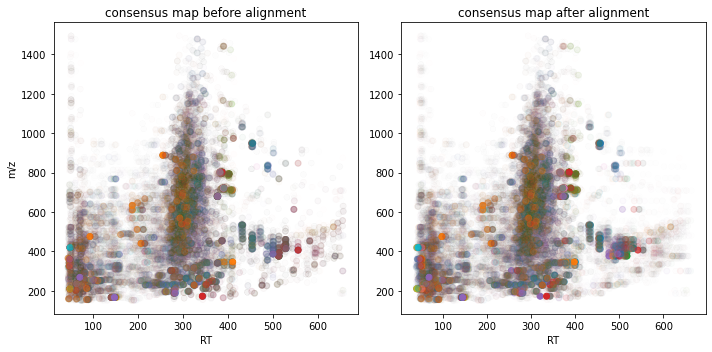

In [17]:
import matplotlib.pyplot as plt
import numpy as np

feature_maps = [feature_maps[ref_index]] + feature_maps[:ref_index] + feature_maps[ref_index+1:]

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('consensus map before alignment')
ax.set_ylabel('m/z')
ax.set_xlabel('RT')

# use alpha value to display feature intensity
ax.scatter([f.getRT() for f in feature_maps[0]], [f.getMZ() for f in feature_maps[0]],
            alpha = np.asarray([f.getIntensity() for f in feature_maps[0]])/max([f.getIntensity() for f in feature_maps[0]]))

for fm in feature_maps[1:]:
    ax.scatter([f.getMetaValue('original_RT') for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

ax = fig.add_subplot(1,2,2)
ax.set_title('consensus map after alignment')
ax.set_xlabel('RT')

for fm in feature_maps:
    ax.scatter([f.getRT() for f in fm], [f.getMZ() for f in fm],
                alpha = np.asarray([f.getIntensity() for f in fm])/max([f.getIntensity() for f in fm]))

fig.tight_layout()
#fig.legend([fmap.getDataProcessing()[0].getMetaValue('parameter: out')[:-11] for fmap in feature_maps], loc = 'lower center')
fig.show()

#### IDMapper: Introduce the features to a protein identification file (idXML)   
Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/TOPP_IDMapper.html

In [18]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob
import os

print(os.getcwd())
    
input_feature_files = sorted(glob.glob("results/GNPSexport/interim/MapAligned*.featureXML"))
print(input_feature_files)

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

use_centroid_rt= False
use_centroid_mz= True
protein_ids = []
peptide_ids= []

mapper = IDMapper()

input_mzml_files= sorted(glob.glob("results/interim/PCpeak_*.mzML"))
print(input_mzml_files)
for filename in input_mzml_files:
    exp = MSExperiment()
    MzMLFile().load(filename, exp)

    for fmap in feature_maps:
        if os.path.basename(fmap.getMetaValue('spectra_data')[0].decode()) == os.path.basename(filename):
            peptide_ids = []
            protein_ids = []
            
            mapper.annotate(fmap, peptide_ids, protein_ids, use_centroid_rt, use_centroid_mz, exp)
            print(fmap.getMetaValue('spectra_data')[0].decode())
        featureidx_file = os.path.join("results", "", "GNPSexport", "", "interim", "", 'IDMapper_' + os.path.basename(fmap.getMetaValue('spectra_data')[0].decode())[7:-5] +".featureXML")
        FeatureXMLFile().store(featureidx_file, fmap)

/Users/eeko/Desktop/pyOpenMS_untargeted_metabolomics
['results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_blank.featureXML', 'results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep1.featureXML', 'results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.featureXML', 'results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.featureXML', 'results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_blank.featureXML', 'results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep1.featureXML', 'results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.featureXML', 'results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep3.featureXML', 'results/GNPSexport/interim/MapAligned_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_blank.featureXML', 'results/GNP

#### The FeatureLinkerUnlabeledKD is used to aggregate the feature information (from single files) into a ConsensusFeature, linking features from different files together, which have a smiliar m/z and rt (no MS2 data).
Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FeatureLinkerUnlabeledKD.html

In [19]:
from pyopenms import *
import pandas as pd
import numpy as np
import os
import glob

In [20]:
class ConsensusMapDF(ConsensusMap):
    def __init__(self):
        super().__init__()

    def get_intensity_df(self):
        labelfree = self.getExperimentType() == "label-free"
        filemeta = self.getColumnHeaders()  # type: dict[int, ColumnHeader]
        labels = list(set([header.label for header in
                           filemeta.values()]))  # TODO could be more efficient. Do we require same channels in all files?
        files = list(set([header.filename for header in filemeta.values()]))
        label_to_idx = {k: v for v, k in enumerate(labels)}
        file_to_idx = {k: v for v, k in enumerate(files)}

        def gen(cmap: ConsensusMap, fun):
            for f in cmap:
                yield from fun(f)

        if not labelfree:
            # TODO write two functions for LF and labelled. One has only one channel, the other has only one file per CF
            def extractRowBlocksChannelWideFileLong(f: ConsensusFeature):
                subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
                filerows = defaultdict(lambda: [0] * len(labels))  # TODO use numpy array?
                for fh in subfeatures:
                    header = filemeta[fh.getMapIndex()]
                    row = filerows[header.filename]
                    row[label_to_idx[header.label]] = fh.getIntensity()
                return (f.getUniqueId(), filerows)

            def extractRowsChannelWideFileLong(f: ConsensusFeature):
                uniqueid, rowdict = extractRowBlocksChannelWideFileLong(f)
                for file, row in rowdict.items():
                    row.append(file)
                    yield tuple([uniqueid] + row)

            if len(labels) == 1:
                labels[0] = "intensity"
            dtypes = [('id', np.dtype('uint64'))] + list(zip(labels, ['f'] * len(labels)))
            dtypes.append(('file', 'U300'))
            # For TMT we know that every feature can only be from one file, since feature = PSM
            #cnt = 0
            #for f in self:
            #    cnt += f.size()

            intyarr = np.fromiter(iter=gen(self, extractRowsChannelWideFileLong), dtype=dtypes, count=self.size())
            return pd.DataFrame(intyarr).set_index('id')
        else:
            # Specialized for LabelFree which has to have only one channel
            def extractRowBlocksChannelLongFileWideLF(f: ConsensusFeature):
                subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
                row = [0.] * len(files)  # TODO use numpy array?
                for fh in subfeatures:
                    header = filemeta[fh.getMapIndex()]
                    row[file_to_idx[header.filename]] = fh.getIntensity()
                yield tuple([f.getUniqueId()] + row)

            dtypes = [('id', np.dtype('uint64'))] + list(zip(files, ['f'] * len(files)))
            # cnt = self.size()*len(files) # TODO for this to work, we would need to fill with NAs for CFs that do not go over all files
            cnt = self.size()

            intyarr = np.fromiter(iter=gen(self, extractRowBlocksChannelLongFileWideLF), dtype=dtypes, count=cnt)
            return pd.DataFrame(intyarr).set_index('id')

    def get_metadata_df(self):
        def gen(cmap: ConsensusMap, fun):
            for f in cmap:
                yield from fun(f)

        def extractMetaData(f: ConsensusFeature):
            # subfeatures = f.getFeatureList()  # type: list[FeatureHandle]
            pep = f.getPeptideIdentifications()  # type: list[PeptideIdentification]
            if len(pep) != 0:
                hits = pep[0].getHits()
                if len(hits) != 0:
                    besthit = hits[0]  # type: PeptideHit
                    # TODO what else
                    yield f.getUniqueId(), besthit.getSequence().toString(), f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()
                else:
                    yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()
            else:
                yield f.getUniqueId(), None, f.getCharge(), f.getRT(), f.getMZ(), f.getQuality()

        cnt = self.size()

        mddtypes = [('id', np.dtype('uint64')), ('sequence', 'U200'), ('charge', 'i4'), ('RT', 'f'), ('mz', 'f'),
                    ('quality', 'f')]
        mdarr = np.fromiter(iter=gen(self, extractMetaData), dtype=mddtypes, count=cnt)
        return pd.DataFrame(mdarr).set_index('id')

In [21]:
feature_grouper = FeatureGroupingAlgorithmKD()

consensus_map = ConsensusMapDF()
file_descriptions = consensus_map.getColumnHeaders()

input_feature_files = sorted(glob.glob('results/GNPSexport/interim/IDMapper*.featureXML'))

feature_maps = []
for featurexml_file in input_feature_files:
    fmap = FeatureMap()
    FeatureXMLFile().load(featurexml_file, fmap)
    feature_maps.append(fmap)

for i, feature_map in enumerate(feature_maps):
    file_description = file_descriptions.get(i, ColumnHeader())
    file_description.filename = feature_map.getMetaValue('spectra_data')[0].decode()
    print(file_description.filename)

    file_description.size = feature_map.size()
    # file_description.unique_id = feature_map.getUniqueId() doesn't work on windows
    #print(file_description.unique_id)
    file_descriptions[i] = file_description

feature_grouper.group(feature_maps, consensus_map)
consensus_map.setColumnHeaders(file_descriptions)


Consensus_file= os.path.join("results", "", "GNPSexport", "","interim", "", 'consensus' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, consensus_map)


# get intensities as a DataFrame
intensities = consensus_map.get_intensity_df()

# get meta data as DataFrame
meta_data = consensus_map.get_metadata_df()[['RT', 'mz', 'charge']]

# you can concatenate these two for a "result" DataFrame
result = pd.concat([meta_data, intensities], axis=1)

# if you don't need labeled index, remove it (and/or save with index = False)
result.reset_index(drop=True, inplace=True)

# store as tsv file
result.to_csv('results/GNPSexport/interim/Consensus.tsv', sep = '\t', index = False)

results/interim/PCpeak_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_blank.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep1.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_blank.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep1.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep3.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_blank.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep2.mzML
results/interim/PCpeak_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep3.mzML
results/interim/PCpeak_20210827_UMETAB219_POS

#### Filter out the features that do not have an MS2 pattern
Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FileFilter.html


In [22]:
input_consensus= "results/GNPSexport/interim/consensus.consensusXML"
cmap = ConsensusMap()
ConsensusXMLFile().load(input_consensus, cmap)
new_map= ConsensusMap(cmap)
new_map.clear(False)
for f in cmap:
    if f.getPeptideIdentifications() !=[]:
        new_map.push_back(f)
        
Consensus_file= os.path.join("results", "", "GNPSexport", "", "interim", "",'filtered' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, new_map)

ConsensusXMLFile::store():  found 6688 invalid unique ids


#### Convert to a csv table

In [23]:
input_consensus= "results/GNPSexport/interim/filtered.consensusXML"
con_map = ConsensusMapDF()
ConsensusXMLFile().load(input_consensus, con_map)
display(con_map.get_intensity_df())

file_descriptions = con_map.getColumnHeaders()
   
# get intensities as a DataFrame
con_map.setColumnHeaders(file_descriptions)

intensities = con_map.get_intensity_df()

# get meta data as DataFrame
meta_data = con_map.get_metadata_df()[['RT', 'mz', "charge"]]

# you can concatenate these two for a "result" DataFrame
result = pd.concat([meta_data, intensities], axis=1)

# if you don't need labeled index, remove it (and/or save with index = False)
result.reset_index(drop=True, inplace=True)

# store as tsv file
result.to_csv('results/GNPSexport/interim/filtered_consensus.tsv', sep = '\t', index = False)
    

,results/interim/PCpeak_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_rep2.mzML,results/interim/PCpeak_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep3.mzML,results/interim/PCpeak_PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep1.mzML,results/interim/PCpeak_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep2.mzML,results/interim/PCpeak_20210826_UMETAB219_POS_ISP2_Plate-1_MDNAWGS11_rep1.mzML,results/interim/PCpeak_20211006_UMETAB222_POS_6_FPY12_Plate-11_NBC_00843_rep1.mzML,results/interim/PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_blank.mzML,results/interim/PCpeak_PCpeak_20210827_UMETAB219_POS_DNPM_Plate-2_MDNAWGS14_rep1.mzML,results/interim/PCpeak_20211006_UMETAB222_POS_40_ISP2_Plate-11_NBC_00843_blank.mzML,results/interim/PCpeak_20211006_UMETAB222_POS_18_FPY12_Plate-11_NBC_00843_rep2.mzML,...,results/interim/PCpeak_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_rep3.mzML,results/interim/PCpeak_PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep3.mzML,results/interim/PCpeak_20211006_UMETAB222_POS_17_DNPM_Plate-11_NBC_00843_rep2.mzML,results/interim/PCpeak_20211006_UMETAB222_POS_4_ISP2_Plate-11_NBC_00843_rep1.mzML,results/interim/PCpeak_20211006_UMETAB222_POS_42_FPY12_Plate-11_NBC_00843_blank.mzML,results/interim/PCpeak_20210826_UMETAB219_POS_DNPM_Plate-1_MDNAWGS11_blank.mzML,results/interim/PCpeak_20210827_UMETAB219_POS_ISP2_Plate-2_MDNAWGS14_rep2.mzML,results/interim/PCpeak_20210826_UMETAB219_POS_FPY12_Plate-1_MDNAWGS11_blank.mzML,results/interim/PCpeak_20211006_UMETAB222_POS_29_DNPM_Plate-11_NBC_00843_rep3.mzML,results/interim/PCpeak_20210827_UMETAB219_POS_FPY12_Plate-2_MDNAWGS14_rep2.mzML
id,,,,,,,,,,,,,,,,,,,,,
0,23460470.0,8631237.0,5242951.0,13423620.0,4922100.0,1.795107e+07,8919085.0,9957446.0,2792170.0,15100300.0,...,14076760.0,1644674.0,2521677.0,3491061.0,10686050.0,7443680.0,1.962420e+06,30551950.0,2208030.0,6956869.0
0,8881861.0,4992339.0,2025389.0,9434231.0,4117613.0,3.621176e+06,2824778.0,6640277.0,2700853.0,2665060.0,...,8763564.0,4262092.0,2240223.0,2980725.0,2952004.0,3699400.0,4.470871e+06,12793220.0,1402128.0,2312600.0
0,55878080.0,66059480.0,16124980.0,137001200.0,12083710.0,4.539911e+07,12672740.0,79692448.0,25535300.0,38975220.0,...,136163504.0,9886484.0,114985200.0,16987770.0,42959832.0,121834096.0,8.470678e+06,48087800.0,124948096.0,7442163.0
0,15444460.0,13708230.0,2733415.0,19377870.0,2558860.0,5.336683e+06,6982376.0,15664220.0,2246483.0,3890510.0,...,13692410.0,4729806.0,1964780.0,2620184.0,5709616.0,13193210.0,7.286438e+05,19822080.0,2600414.0,2697249.0
0,48305968.0,7893263.0,8776934.0,53082512.0,23091020.0,2.678875e+07,19129270.0,8819608.0,23348760.0,24493060.0,...,45685432.0,10398600.0,12442700.0,10452810.0,17584040.0,36532420.0,1.220015e+07,55692720.0,12603810.0,9347569.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,3.391787e+05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,8.230814e+05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,0.0,0.0


#### Copy mzML files to the GNPSexport directory (needed for FBMN)

In [24]:
input_mzml_files=glob.glob("results/interim/PCpeak_*.mzML")

for mzml_file in input_mzml_files:
    exp= MSExperiment()
    MzMLFile().load(mzml_file, exp)
    ff_file = os.path.join("results", "", "GNPSexport", "", os.path.basename(mzml_file)[7:])
    MzMLFile().store(ff_file, exp)

#### GNPS_export creates an mgf file with only the MS2 information of all files (introduce mzml files with spaces between them)
Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/TOPP_GNPSExport.html

In [25]:
!resources/OpenMS-2.7.0/bin/GNPSExport -ini resources/GNPSExport.ini -in_cm results/GNPSexport/interim/filtered.consensusXML -in_mzml results/GNPSexport/*.mzML -out results/GNPSexport/MSMS.mgf

Your current parameters are still valid, but there might be new valid values or even new parameters. Upgrading the INI might be useful.
Progress of 'parsing features and ms2 identifications...':
  82.62 %               GNPSExport took 48.80 s (wall), 47.64 s (CPU), 2.60 s (system), 45.04 s (user); Peak Memory Usage: 1247 MB.


#### export the consensusXML file to a txt file for GNPS
Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_TextExporter.html

In [26]:
!resources/OpenMS-2.7.0/bin/TextExporter -in results/GNPSexport/interim/filtered.consensusXML -out results/GNPSexport/FeatureQuantificationTable.txt

TextExporter took 2.07 s (wall), 2.01 s (CPU), 0.11 s (system), 1.90 s (user); Peak Memory Usage: 46 MB.
